In [1]:
!uv add seaborn plt numpy pandas matplotlib

Resolved 39 packages in 347ms                                        
⠙ Preparing packages... (0/1)                                                   
⠙ Preparing packages... (0/1)-------------------     0 B/257.71 KiB          
⠙ Preparing packages... (0/1)------------------- 16.00 KiB/257.71 KiB        
⠙ Preparing packages... (0/1)------------------- 32.00 KiB/257.71 KiB        
⠙ Preparing packages... (0/1)------------------- 48.00 KiB/257.71 KiB        
⠙ Preparing packages... (0/1)------------------- 64.00 KiB/257.71 KiB        
⠙ Preparing packages... (0/1)------------------- 80.00 KiB/257.71 KiB        
⠙ Preparing packages... (0/1)------------------- 96.00 KiB/257.71 KiB        
⠙ Preparing packages... (0/1)2m----------------- 112.00 KiB/257.71 KiB       
⠙ Preparing packages... (0/1)---------------- 128.00 KiB/257.71 KiB       
⠙ Preparing packages... (0/1)m-------------- 144.00 KiB/257.71 KiB       
⠙ Preparing packages... (0/1)30m------------ 160.00 KiB/257.71 KiB       
⠙ 

In [2]:
import re
import os
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from tqdm.auto import tqdm

warnings.filterwarnings("ignore")
plt.rcParams["font.family"] = "AppleGothic"
plt.rcParams["axes.unicode_minus"] = False
pd.set_option("display.max_columns", 60)
pd.set_option("display.max_rows", 100)

# 시각화 전역 스타일 (전체 노트북 일관 적용)
plt.rcParams.update({
    "figure.facecolor": "white",
    "axes.facecolor": "#fafafa",
    "axes.grid": True,
    "grid.alpha": 0.35,
    "axes.edgecolor": "#2c3e50",
    "axes.linewidth": 0.8,
    "xtick.color": "#34495e",
    "ytick.color": "#34495e",
})
# 시각화 색상 팔레트 (EDA/전처리 공통)
VIZ_COLORS = {
    "primary": "#3498db",
    "secondary": "#e67e22",
    "success": "#27ae60",
    "danger": "#e74c3c",
    "gray": "#95a5a6",
    "palette": ["#3498db", "#e67e22", "#27ae60", "#9b59b6", "#1abc9c"],
}

# 프로젝트 경로 설정
# 우선순위: 노트북 파일 경로(__vsc_ipynb_file__) > os.getcwd() > 절대 경로 폴백
def _resolve_project_root() -> Path:
    """노트북이 어디서 실행되든 프로젝트 루트를 안정적으로 찾습니다."""
    # 1) Cursor/VS Code 노트북 환경: __vsc_ipynb_file__ 변수 활용
    ipynb_file = globals().get("__vsc_ipynb_file__")
    if ipynb_file:
        return Path(ipynb_file).resolve().parent.parent

    # 2) 일반 Jupyter 환경: os.getcwd() 시도
    try:
        cwd = Path(os.getcwd())
        # notebooks/ 폴더 안에서 실행 중인 경우
        if cwd.name == "notebooks":
            return cwd.parent
        # 프로젝트 루트에서 실행 중인 경우
        if (cwd / "assets" / "data").exists():
            return cwd
        # 그 외: 한 단계 위가 프로젝트 루트
        return cwd.parent
    except OSError:
        pass

    # 3) 폴백: 절대 경로 직접 지정
    return Path("/Users/tylersong/Desktop/workspace/learn/team_prj/report/house-price-prediction")

PROJECT_ROOT = _resolve_project_root()
DATA_DIR = PROJECT_ROOT / "assets" / "data"

# 원격 서버 경로 (해당 시 자동 전환)
REMOTE_DATA_DIR = Path("/data/ephemeral/home/data")
if REMOTE_DATA_DIR.exists():
    DATA_DIR = REMOTE_DATA_DIR

print(f"프로젝트 루트: {PROJECT_ROOT}")
print(f"데이터 디렉토리: {DATA_DIR}")
print(f"데이터 존재 여부: {DATA_DIR.exists()}")

프로젝트 루트: /Users/tylersong/Desktop/workspace/learn/team_prj/report/house-price-prediction
데이터 디렉토리: /Users/tylersong/Desktop/workspace/learn/team_prj/report/house-price-prediction/assets/data
데이터 존재 여부: False


## 1. 데이터 로드 및 기초 탐색

In [5]:
# ── 데이터 로드 ──
train_df = pd.read_csv(DATA_DIR / "train.csv")
test_df = pd.read_csv(DATA_DIR / "test.csv")

print(f"학습 데이터: {train_df.shape}")
print(f"테스트 데이터: {test_df.shape}")
print(f"\n학습 데이터 컬럼 목록 ({len(train_df.columns)}개):")
print(train_df.columns.tolist())

학습 데이터: (1118822, 52)
테스트 데이터: (9272, 51)

학습 데이터 컬럼 목록 (52개):
['시군구', '번지', '본번', '부번', '아파트명', '전용면적(㎡)', '계약년월', '계약일', '층', '건축년도', '도로명', '해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', 'k-단지분류(아파트,주상복합등등)', 'k-전화번호', 'k-팩스번호', '단지소개기존clob', 'k-세대타입(분양형태)', 'k-관리방식', 'k-복도유형', 'k-난방방식', 'k-전체동수', 'k-전체세대수', 'k-건설사(시공사)', 'k-시행사', 'k-사용검사일-사용승인일', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과', 'k-홈페이지', 'k-등록일자', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '좌표X', '좌표Y', '단지신청일', 'target']


In [ ]:
# ── 기초 통계 확인 ──
print("=" * 60)
print("학습 데이터 기초 정보")
print("=" * 60)
train_df.info(verbose=True, show_counts=True)

학습 데이터 기초 정보
<class 'pandas.DataFrame'>
RangeIndex: 1118822 entries, 0 to 1118821
Data columns (total 52 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   시군구                     1118822 non-null  str    
 1   번지                      1118597 non-null  str    
 2   본번                      1118747 non-null  float64
 3   부번                      1118747 non-null  float64
 4   아파트명                    1116696 non-null  str    
 5   전용면적(㎡)                 1118822 non-null  float64
 6   계약년월                    1118822 non-null  int64  
 7   계약일                     1118822 non-null  int64  
 8   층                       1118822 non-null  int64  
 9   건축년도                    1118822 non-null  int64  
 10  도로명                     1118822 non-null  str    
 11  해제사유발생일                 5983 non-null     float64
 12  등기신청일자                  1118822 non-null  str    
 13  거래유형                    1118822 non-null  str    
 14  

In [ ]:
# ── 수치형 기술통계 ──
train_df.describe()

,본번,부번,전용면적(㎡),계약년월,계약일,층,건축년도,해제사유발생일,단지소개기존clob,k-전체동수,k-전체세대수,k-연면적,k-주거전용면적,k-관리비부과면적,k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-85㎡~135㎡이하,k-135㎡초과,건축면적,주차대수,좌표X,좌표Y,target
count,1.118747e+06,1.118747e+06,1.118822e+06,1.118822e+06,1.118822e+06,1.118822e+06,1.118822e+06,5.983000e+03,68582.000000,248192.000000,249259.000000,2.492590e+05,249214.000000,249259.000000,249214.000000,249214.000000,249214.000000,327.0,2.491080e+05,249108.000000,249152.000000,249152.000000,1.118822e+06
mean,5.649108e+02,5.978885e+00,7.717475e+01,2.014760e+05,1.580656e+01,8.871968e+00,1.998755e+03,2.021057e+07,541.529979,14.798346,1184.124593,1.614967e+05,94210.104998,120726.487549,477.912838,476.713439,167.528470,70.0,1.895070e+05,1063.678778,126.995228,37.545785,5.799153e+04
std,5.160642e+02,4.668584e+01,2.936423e+01,4.187868e+02,8.721166e+00,5.982584e+00,9.333908e+00,1.060697e+04,751.809853,17.693533,1191.474680,1.839856e+05,101905.956897,129020.276480,759.909400,727.553569,248.928143,0.0,1.729027e+06,1235.437604,0.091045,0.052483,4.642602e+04
min,0.000000e+00,0.000000e+00,1.002000e+01,2.007010e+05,1.000000e+00,-4.000000e+00,1.961000e+03,2.020022e+07,1.000000,1.000000,59.000000,0.000000e+00,2338.000000,0.000000,0.000000,0.000000,0.000000,70.0,0.000000e+00,0.000000,126.798318,37.447843,3.500000e+02
25%,1.760000e+02,0.000000e+00,5.965000e+01,2.011100e+05,8.000000e+00,4.000000e+00,1.992000e+03,2.020082e+07,4.000000,5.000000,403.000000,5.366600e+04,31934.000000,40735.000000,48.000000,95.000000,0.000000,70.0,0.000000e+00,315.000000,126.913157,37.499201,3.050000e+04
50%,4.700000e+02,0.000000e+00,8.188000e+01,2.015070e+05,1.600000e+01,8.000000e+00,2.000000e+03,2.021030e+07,174.000000,10.000000,768.000000,1.016330e+05,60280.000000,78125.000000,225.000000,256.000000,63.000000,70.0,1.710550e+03,683.000000,127.014971,37.544936,4.480000e+04
75%,7.810000e+02,1.000000e+00,8.496000e+01,2.018040e+05,2.300000e+01,1.200000e+01,2.005000e+03,2.022021e+07,725.000000,17.000000,1622.000000,2.039040e+05,117086.000000,159544.000000,576.000000,582.000000,237.000000,70.0,8.414210e+03,1274.000000,127.059590,37.577117,6.980000e+04
max,4.974000e+03,2.837000e+03,4.243200e+02,2.023060e+05,3.100000e+01,6.900000e+01,2.023000e+03,2.023093e+07,2888.000000,124.000000,9510.000000,9.591851e+06,734781.000000,969877.000000,4975.000000,5132.000000,1500.000000,70.0,3.159620e+07,12096.000000,127.179998,37.687725,1.450000e+06


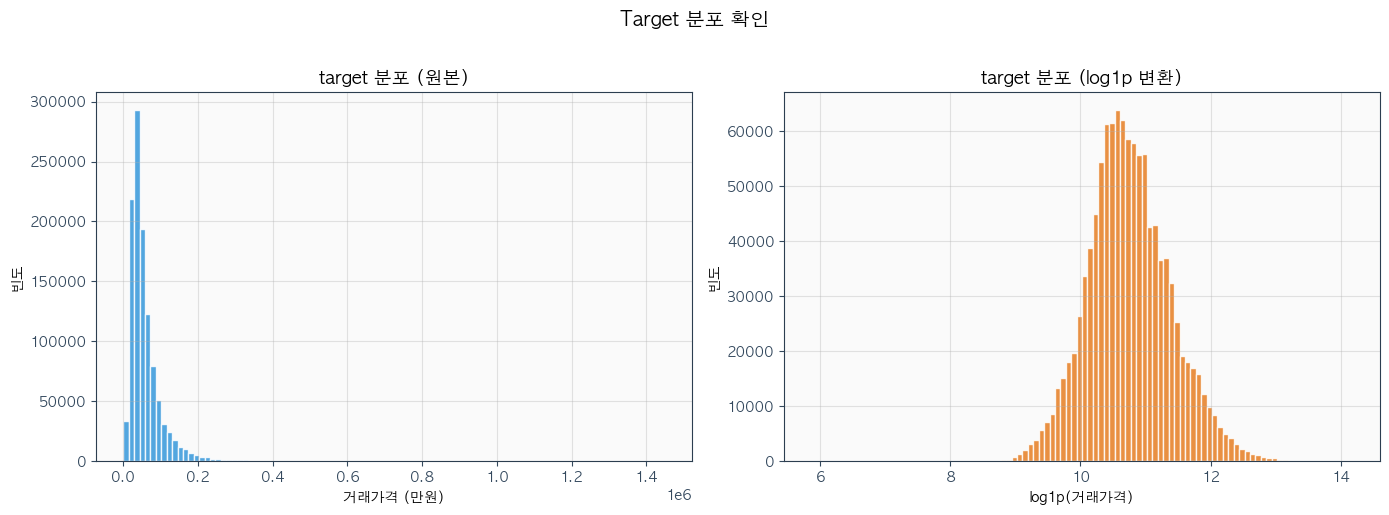

target 왜도(skewness): 3.5176
log1p(target) 왜도: 0.2813


In [ ]:
# ── target 분포 확인 ──
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(train_df["target"], bins=100, color=VIZ_COLORS["primary"], edgecolor="white", alpha=0.85)
axes[0].set_title("target 분포 (원본)", fontsize=13, fontweight="bold")
axes[0].set_xlabel("거래가격 (만원)")
axes[0].set_ylabel("빈도")

axes[1].hist(np.log1p(train_df["target"]), bins=100, color=VIZ_COLORS["secondary"], edgecolor="white", alpha=0.85)
axes[1].set_title("target 분포 (log1p 변환)", fontsize=13, fontweight="bold")
axes[1].set_xlabel("log1p(거래가격)")
axes[1].set_ylabel("빈도")

plt.suptitle("Target 분포 확인", fontsize=14, y=1.02, fontweight="bold")
plt.tight_layout()
plt.show()

print(f"target 왜도(skewness): {train_df['target'].skew():.4f}")
print(f"log1p(target) 왜도: {np.log1p(train_df['target']).skew():.4f}")

In [ ]:
# ── 결측 비율 확인 ──
missing = train_df.isnull().sum()
missing_pct = (missing / len(train_df) * 100).round(2)
missing_info = pd.DataFrame({
    "결측 수": missing,
    "결측 비율(%)": missing_pct,
}).sort_values("결측 비율(%)", ascending=False)

print("결측 비율이 높은 컬럼 (상위 20개):")
print(missing_info[missing_info["결측 비율(%)"] > 0].head(20))

결측 비율이 높은 컬럼 (상위 20개):
                       결측 수  결측 비율(%)
k-135㎡초과            1118495     99.97
해제사유발생일             1112839     99.47
k-등록일자              1107832     99.02
단지소개기존clob          1050240     93.87
k-홈페이지              1005647     89.88
고용보험관리번호             913304     81.63
세대전기계약방법             878747     78.54
k-팩스번호               872742     78.01
청소비관리형태              871178     77.87
k-시행사                871254     77.87
k-건설사(시공사)           871058     77.85
경비비관리형태              870988     77.85
k-단지분류(아파트,주상복합등등)   870691     77.82
k-전체동수               870630     77.82
단지승인일                870286     77.79
k-전화번호               870274     77.78
k-복도유형               869890     77.75
건축면적                 869714     77.73
좌표X                  869670     77.73
k-수정일자               869608     77.73


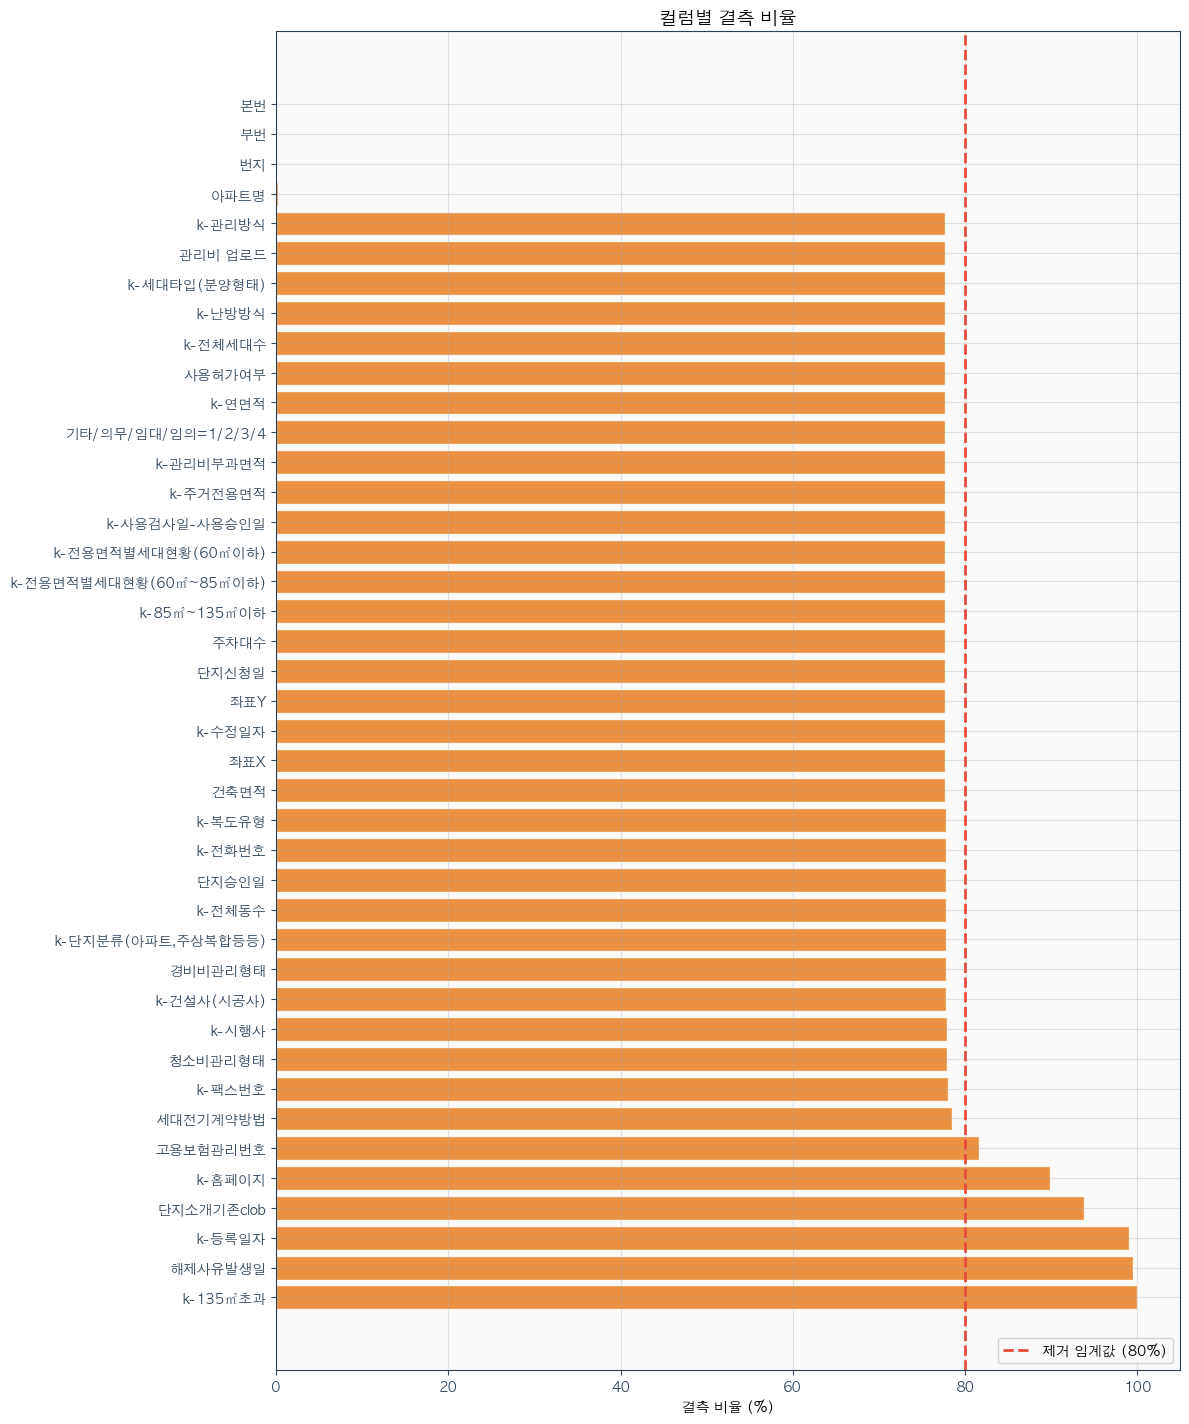

In [ ]:
# ── 결측 비율 시각화 (결측이 있는 컬럼만) ──
missing_cols = missing_info[missing_info["결측 비율(%)"] > 0]

if len(missing_cols) > 0:
    fig, ax = plt.subplots(figsize=(12, max(6, len(missing_cols) * 0.35)))
    ax.barh(missing_cols.index, missing_cols["결측 비율(%)"], color=VIZ_COLORS["secondary"], edgecolor="white", alpha=0.85)
    ax.set_xlabel("결측 비율 (%)")
    ax.set_title("컬럼별 결측 비율", fontsize=13, fontweight="bold")
    ax.axvline(x=80, color=VIZ_COLORS["danger"], linestyle="--", linewidth=2, label="제거 임계값 (80%)")
    ax.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

---

## EDA (탐색적 데이터 분석)

전처리 전략을 수립하기 위해 원본 데이터의 분포, 상관관계, 시계열 트렌드, 지리적 패턴을 분석합니다.

### EDA 목차
1. Target 심층 분석 (분포, 가격대별, 세대타입별)
2. 주요 수치형 피처 분포 및 Target 상관관계
3. 범주형 피처별 Target 분포
4. 시계열 트렌드 (연도/월별 거래 건수 및 가격 추이)
5. 좌표 기반 지리적 분포
6. Train / Test 분포 비교
7. 수치형 피처 간 상관관계 히트맵

### EDA-1. Target 심층 분석

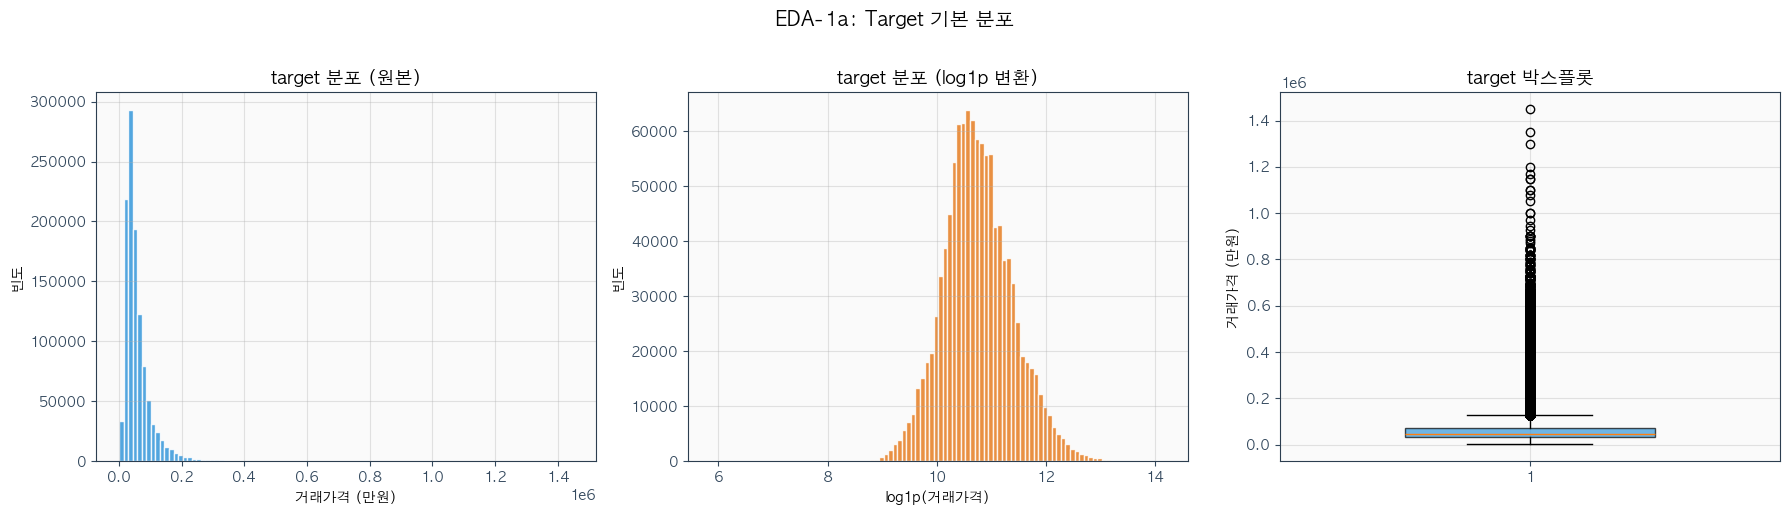

target 기본 통계:
  평균:            57,992 만원
  중앙값:          44,800 만원
  표준편차:         46,426 만원
  최소:               350 만원
  최대:         1,450,000 만원
  왜도(skewness):  3.5176
  첨도(kurtosis):  25.4654
  log1p 왜도:      0.2813


In [ ]:
# ── EDA-1a: Target 기본 분포 (원본 vs log1p) ──
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 원본 분포
axes[0].hist(train_df["target"], bins=100, color=VIZ_COLORS["primary"], edgecolor="white", alpha=0.85)
axes[0].set_title("target 분포 (원본)", fontsize=13, fontweight="bold")
axes[0].set_xlabel("거래가격 (만원)")
axes[0].set_ylabel("빈도")

# log1p 분포
axes[1].hist(np.log1p(train_df["target"]), bins=100, color=VIZ_COLORS["secondary"], edgecolor="white", alpha=0.85)
axes[1].set_title("target 분포 (log1p 변환)", fontsize=13, fontweight="bold")
axes[1].set_xlabel("log1p(거래가격)")
axes[1].set_ylabel("빈도")

# 박스플롯
bp = axes[2].boxplot(train_df["target"], vert=True, widths=0.5, patch_artist=True)
bp["boxes"][0].set_facecolor(VIZ_COLORS["primary"])
bp["boxes"][0].set_alpha(0.7)
axes[2].set_title("target 박스플롯", fontsize=13, fontweight="bold")
axes[2].set_ylabel("거래가격 (만원)")

plt.suptitle("EDA-1a: Target 기본 분포", fontsize=14, y=1.02, fontweight="bold")
plt.tight_layout()
plt.show()

print(f"target 기본 통계:")
print(f"  평균:   {train_df['target'].mean():>15,.0f} 만원")
print(f"  중앙값: {train_df['target'].median():>15,.0f} 만원")
print(f"  표준편차:{train_df['target'].std():>15,.0f} 만원")
print(f"  최소:   {train_df['target'].min():>15,.0f} 만원")
print(f"  최대:   {train_df['target'].max():>15,.0f} 만원")
print(f"  왜도(skewness):  {train_df['target'].skew():.4f}")
print(f"  첨도(kurtosis):  {train_df['target'].kurt():.4f}")
print(f"  log1p 왜도:      {np.log1p(train_df['target']).skew():.4f}")

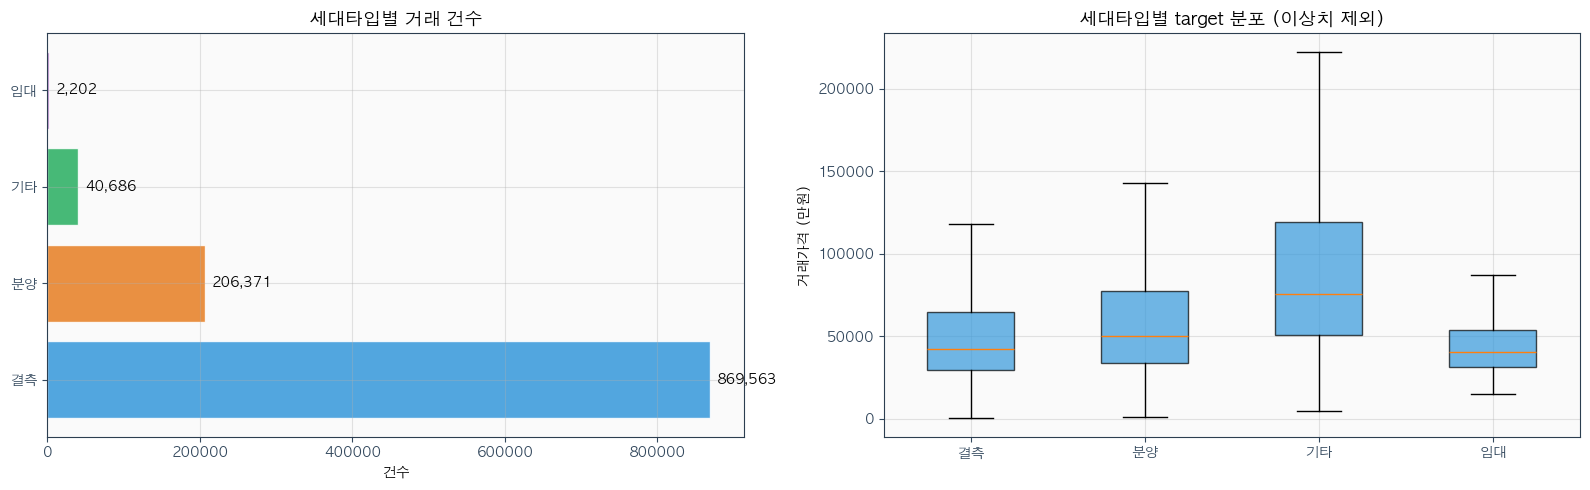

세대타입별 target 통계:
               count     mean   median      std
k-세대타입(분양형태)                                   
결측            869563  54990.0  42500.0  43682.0
기타             40686  96436.0  75502.0  70219.0
분양            206371  63203.0  50000.0  48070.0
임대              2202  44643.0  40500.0  18899.0


In [ ]:
# ── EDA-1b: k-세대타입(분양형태)별 Target 분포 ──
# 분양/임대/기타에 따라 target 의미가 다름 (매매가 vs 전세보증금)
type_col = "k-세대타입(분양형태)"
if type_col in train_df.columns:
    temp = train_df[[type_col, "target"]].copy()
    temp[type_col] = temp[type_col].fillna("결측")

    fig, axes = plt.subplots(1, 2, figsize=(16, 5))

    # 건수 비교
    counts = temp[type_col].value_counts()
    colors = [VIZ_COLORS["palette"][i % len(VIZ_COLORS["palette"])] for i in range(len(counts))]
    axes[0].barh(counts.index, counts.values, color=colors, edgecolor="white", alpha=0.85)
    axes[0].set_title("세대타입별 거래 건수", fontsize=13, fontweight="bold")
    axes[0].set_xlabel("건수")
    for i, (idx, v) in enumerate(counts.items()):
        axes[0].text(v + counts.max() * 0.01, i, f"{v:,}", va="center", fontsize=10)

    # 가격 분포 (박스플롯)
    type_order = temp[type_col].value_counts().index.tolist()
    data_list = [temp[temp[type_col] == t]["target"].values for t in type_order]
    bp = axes[1].boxplot(data_list, labels=type_order, vert=True, widths=0.5, showfliers=False, patch_artist=True)
    for patch in bp["boxes"]:
        patch.set_facecolor(VIZ_COLORS["primary"])
        patch.set_alpha(0.7)
    axes[1].set_title("세대타입별 target 분포 (이상치 제외)", fontsize=13, fontweight="bold")
    axes[1].set_ylabel("거래가격 (만원)")

    plt.tight_layout()
    plt.show()

    # 통계표
    print("세대타입별 target 통계:")
    print(temp.groupby(type_col)["target"].agg(["count", "mean", "median", "std"]).round(0).to_string())
else:
    print(f"'{type_col}' 컬럼이 데이터에 없습니다.")

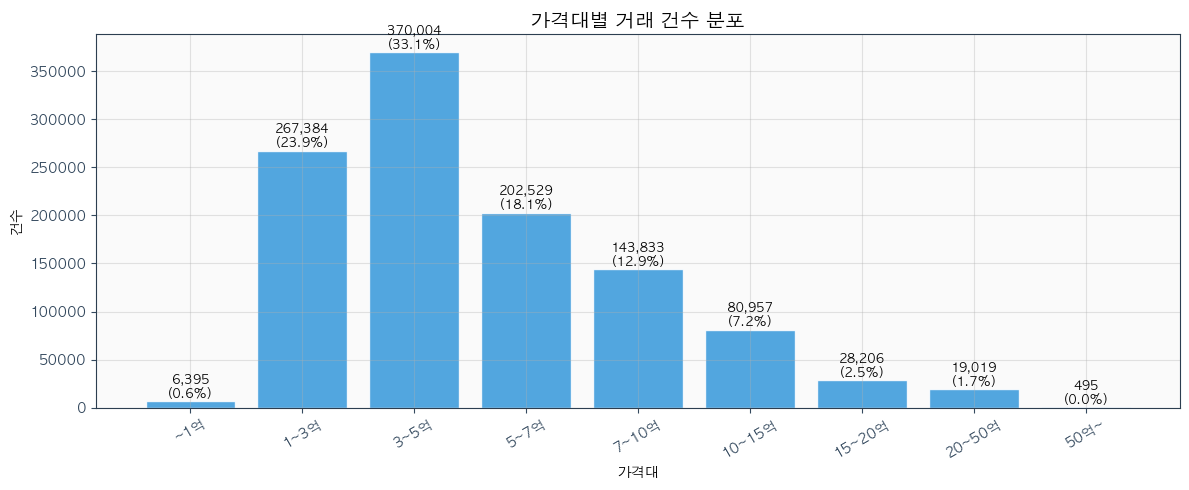

In [ ]:
# ── EDA-1c: 가격대별 분포 ──
price_bins = [0, 10000, 30000, 50000, 70000, 100000, 150000, 200000, 500000, float("inf")]
price_labels = [
    "~1억", "1~3억", "3~5억", "5~7억", "7~10억",
    "10~15억", "15~20억", "20~50억", "50억~"
]
train_df["price_range"] = pd.cut(train_df["target"], bins=price_bins, labels=price_labels)

fig, ax = plt.subplots(figsize=(12, 5))
counts = train_df["price_range"].value_counts().reindex(price_labels)
bars = ax.bar(counts.index, counts.values, color=VIZ_COLORS["primary"], edgecolor="white", alpha=0.85)
ax.set_title("가격대별 거래 건수 분포", fontsize=14, fontweight="bold")
ax.set_xlabel("가격대")
ax.set_ylabel("건수")
plt.xticks(rotation=30)

for bar, v in zip(bars, counts.values):
    ax.text(bar.get_x() + bar.get_width() / 2, v + counts.max() * 0.01,
            f"{v:,}\n({v/len(train_df)*100:.1f}%)", ha="center", fontsize=9)

plt.tight_layout()
plt.show()

# 정리
train_df.drop(columns=["price_range"], inplace=True)

### EDA-2. 주요 수치형 피처 분포 및 Target 상관관계

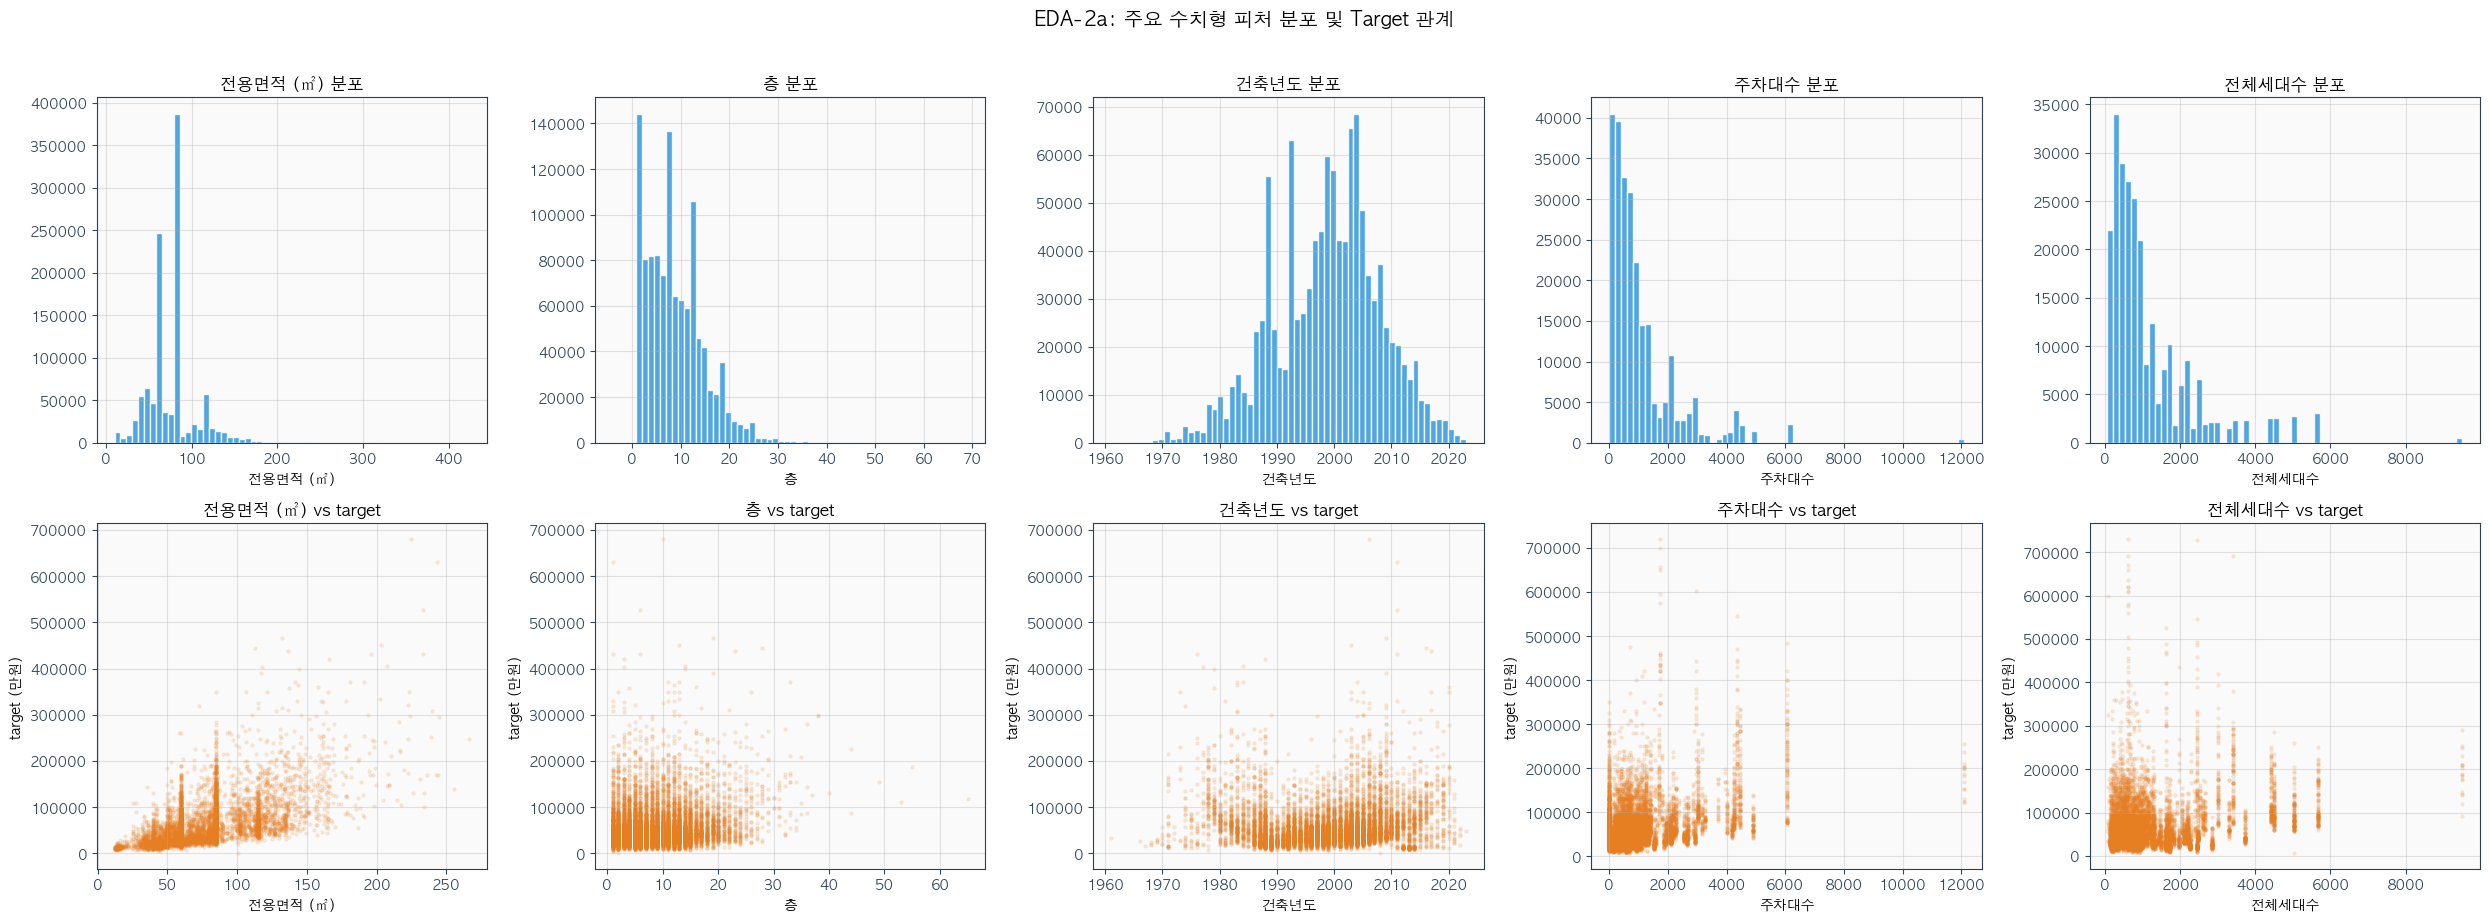

In [ ]:
# ── EDA-2a: 주요 수치형 피처 분포 ──
num_features = {
    "전용면적(㎡)": "전용면적 (㎡)",
    "층": "층",
    "건축년도": "건축년도",
    "주차대수": "주차대수",
    "k-전체세대수": "전체세대수",
}
available = {k: v for k, v in num_features.items() if k in train_df.columns}

fig, axes = plt.subplots(2, len(available), figsize=(5 * len(available), 9))

for i, (col, label) in enumerate(available.items()):
    # 상단: 히스토그램
    axes[0, i].hist(train_df[col].dropna(), bins=60, color=VIZ_COLORS["primary"], edgecolor="white", alpha=0.85)
    axes[0, i].set_title(f"{label} 분포", fontsize=12, fontweight="bold")
    axes[0, i].set_xlabel(label)

    # 하단: target과의 scatter (샘플링)
    sample = train_df[[col, "target"]].dropna().sample(min(10000, len(train_df)), random_state=42)
    axes[1, i].scatter(sample[col], sample["target"], alpha=0.12, s=5, color=VIZ_COLORS["secondary"])
    axes[1, i].set_title(f"{label} vs target", fontsize=12)
    axes[1, i].set_xlabel(label)
    axes[1, i].set_ylabel("target (만원)")

plt.suptitle("EDA-2a: 주요 수치형 피처 분포 및 Target 관계", fontsize=14, y=1.02, fontweight="bold")
plt.tight_layout()
plt.show()

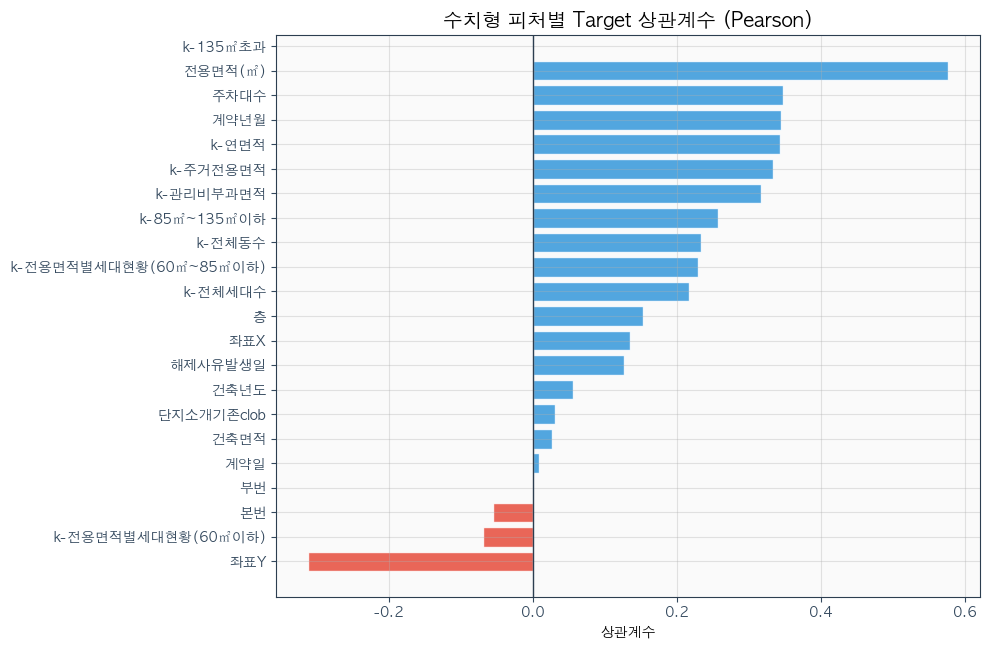

상관계수 상위 10개:
전용면적(㎡)                   0.577041
주차대수                      0.348141
계약년월                      0.344665
k-연면적                     0.343594
k-주거전용면적                  0.334076
k-관리비부과면적                 0.316773
좌표Y                       0.312180
k-85㎡~135㎡이하              0.257145
k-전체동수                    0.234470
k-전용면적별세대현황(60㎡~85㎡이하)    0.229618


In [ ]:
# ── EDA-2b: 수치형 피처별 Target 상관계수 ──
num_cols_for_corr = [c for c in train_df.select_dtypes(include=[np.number]).columns if c != "target"]
corr_with_target = train_df[num_cols_for_corr + ["target"]].corr()["target"].drop("target").sort_values()

fig, ax = plt.subplots(figsize=(10, max(6, len(corr_with_target) * 0.3)))
colors = [VIZ_COLORS["danger"] if v < 0 else VIZ_COLORS["primary"] for v in corr_with_target.values]
ax.barh(corr_with_target.index, corr_with_target.values, color=colors, edgecolor="white", alpha=0.85)
ax.set_title("수치형 피처별 Target 상관계수 (Pearson)", fontsize=14, fontweight="bold")
ax.set_xlabel("상관계수")
ax.axvline(x=0, color="#2c3e50", linewidth=1)
plt.tight_layout()
plt.show()

print("상관계수 상위 10개:")
print(corr_with_target.abs().sort_values(ascending=False).head(10).to_string())

### EDA-3. 범주형 피처별 Target 분포

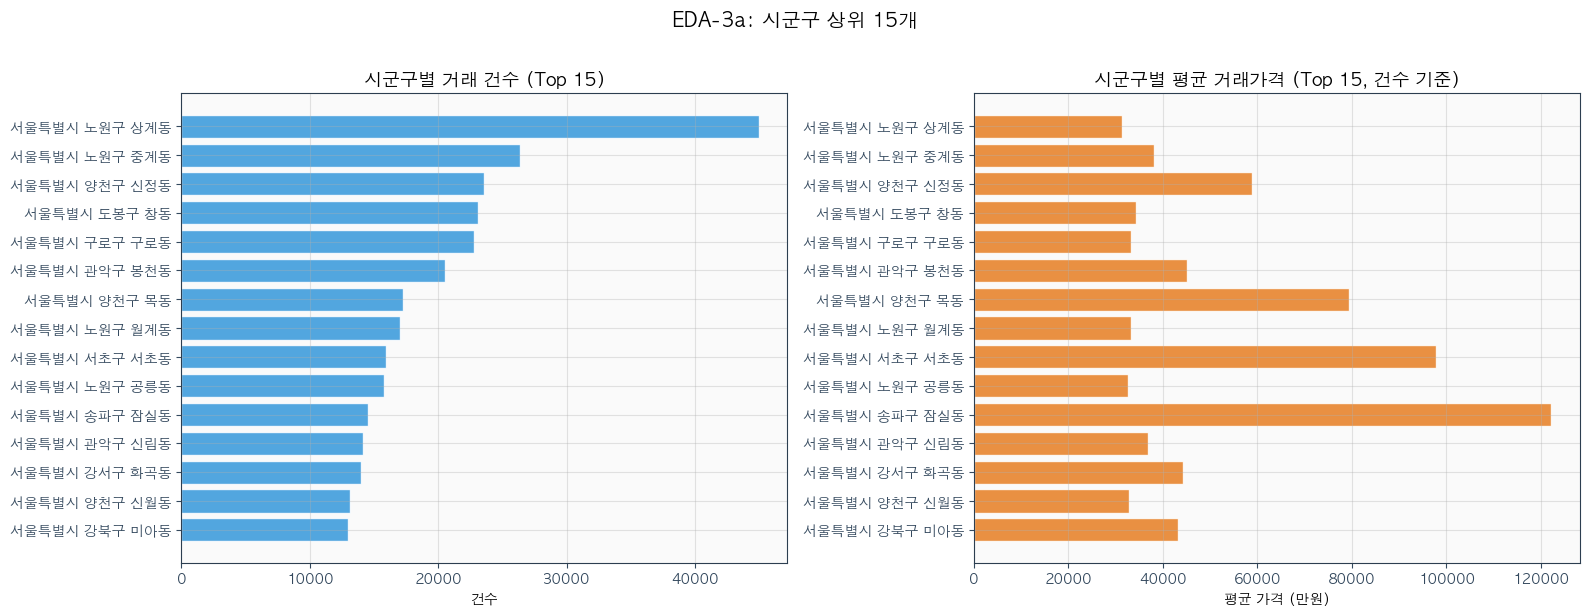

In [ ]:
# ── EDA-3a: 시군구 상위 15개 — 거래 건수 및 평균 가격 ──
sigungu_stats = (
    train_df.groupby("시군구")["target"]
    .agg(["count", "mean", "median"])
    .sort_values("count", ascending=False)
    .head(15)
)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 거래 건수
axes[0].barh(sigungu_stats.index[::-1], sigungu_stats["count"][::-1], color=VIZ_COLORS["primary"], edgecolor="white", alpha=0.85)
axes[0].set_title("시군구별 거래 건수 (Top 15)", fontsize=13, fontweight="bold")
axes[0].set_xlabel("건수")

# 평균 가격
axes[1].barh(sigungu_stats.index[::-1], sigungu_stats["mean"][::-1], color=VIZ_COLORS["secondary"], edgecolor="white", alpha=0.85)
axes[1].set_title("시군구별 평균 거래가격 (Top 15, 건수 기준)", fontsize=13, fontweight="bold")
axes[1].set_xlabel("평균 가격 (만원)")

plt.suptitle("EDA-3a: 시군구 상위 15개", fontsize=14, y=1.02, fontweight="bold")
plt.tight_layout()
plt.show()

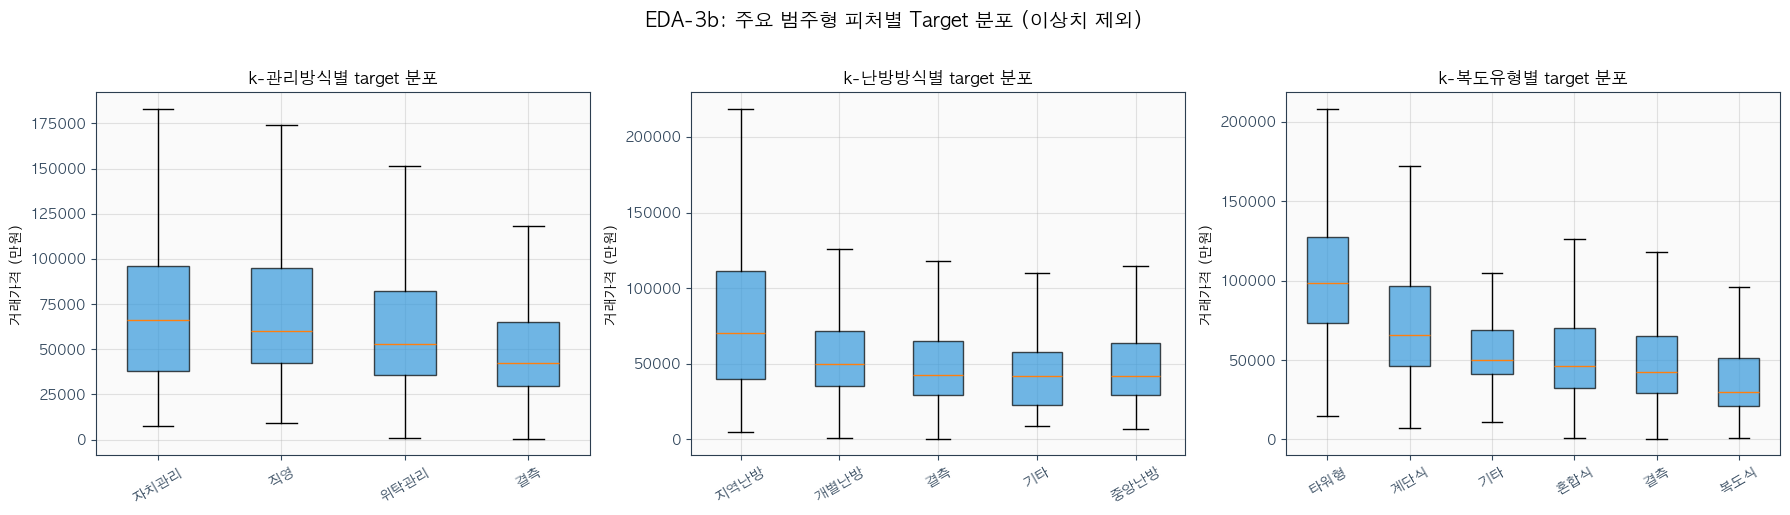

In [ ]:
# ── EDA-3b: k-관리방식, k-난방방식, k-복도유형별 target 분포 ──
cat_features = ["k-관리방식", "k-난방방식", "k-복도유형"]
cat_available = [c for c in cat_features if c in train_df.columns]

if cat_available:
    fig, axes = plt.subplots(1, len(cat_available), figsize=(6 * len(cat_available), 5))
    if len(cat_available) == 1:
        axes = [axes]

    for ax, col in zip(axes, cat_available):
        temp = train_df[[col, "target"]].copy()
        temp[col] = temp[col].fillna("결측")
        order = temp.groupby(col)["target"].median().sort_values(ascending=False).index
        data_list = [temp[temp[col] == cat]["target"].values for cat in order]
        bp = ax.boxplot(data_list, labels=order, vert=True, widths=0.5, showfliers=False, patch_artist=True)
        for patch in bp["boxes"]:
            patch.set_facecolor(VIZ_COLORS["primary"])
            patch.set_alpha(0.7)
        ax.set_title(f"{col}별 target 분포", fontsize=12, fontweight="bold")
        ax.set_ylabel("거래가격 (만원)")
        ax.tick_params(axis="x", rotation=30)

    plt.suptitle("EDA-3b: 주요 범주형 피처별 Target 분포 (이상치 제외)", fontsize=14, y=1.02, fontweight="bold")
    plt.tight_layout()
    plt.show()

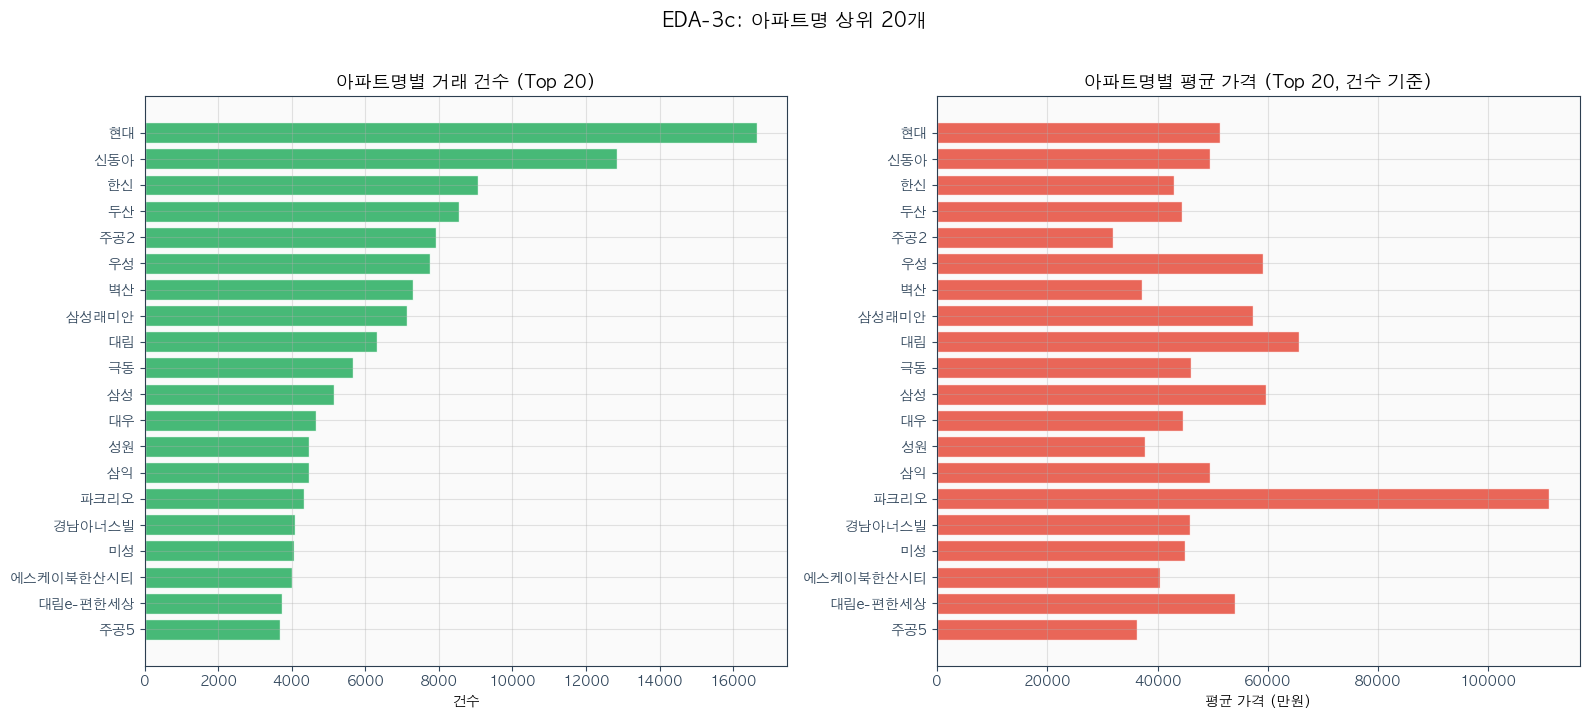

아파트명 고유값 수: 6,538개


In [ ]:
# ── EDA-3c: 아파트명 상위 20개 — 거래 건수 및 평균 가격 ──
apt_stats = (
    train_df.groupby("아파트명")["target"]
    .agg(["count", "mean"])
    .sort_values("count", ascending=False)
    .head(20)
)

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

axes[0].barh(apt_stats.index[::-1], apt_stats["count"][::-1], color=VIZ_COLORS["success"], edgecolor="white", alpha=0.85)
axes[0].set_title("아파트명별 거래 건수 (Top 20)", fontsize=13, fontweight="bold")
axes[0].set_xlabel("건수")

axes[1].barh(apt_stats.index[::-1], apt_stats["mean"][::-1], color=VIZ_COLORS["danger"], edgecolor="white", alpha=0.85)
axes[1].set_title("아파트명별 평균 가격 (Top 20, 건수 기준)", fontsize=13, fontweight="bold")
axes[1].set_xlabel("평균 가격 (만원)")

plt.suptitle("EDA-3c: 아파트명 상위 20개", fontsize=14, y=1.02, fontweight="bold")
plt.tight_layout()
plt.show()

print(f"아파트명 고유값 수: {train_df['아파트명'].nunique():,}개")

### EDA-4. 시계열 트렌드 (연도/월별 거래 건수 및 가격 추이)

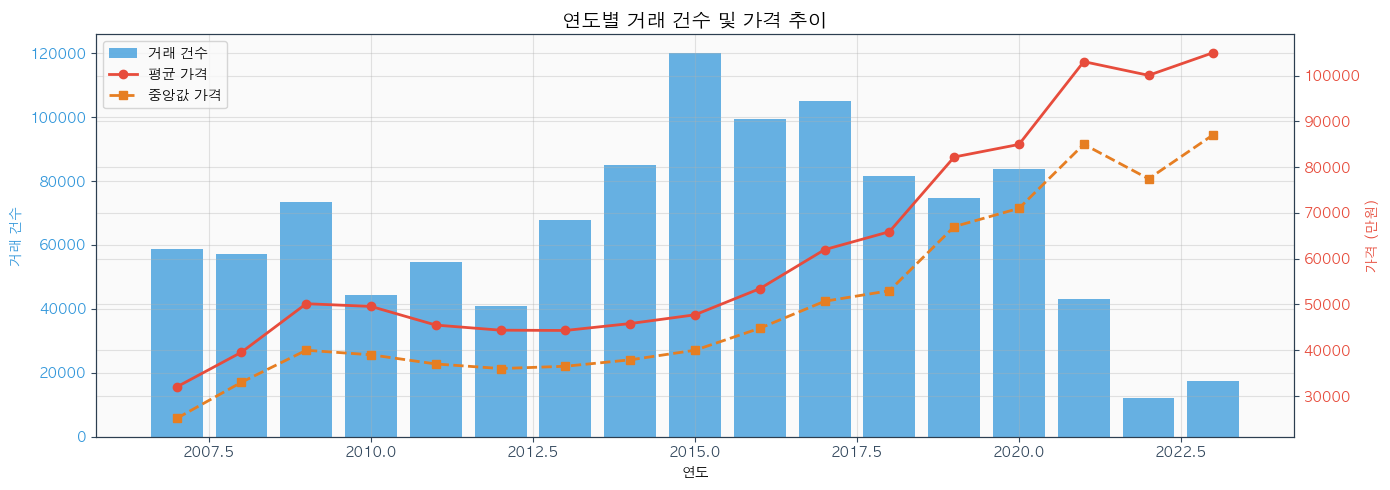

In [ ]:
# ── EDA-4a: 연도별 거래 건수 및 평균 가격 추이 ──
ym = train_df["계약년월"].astype(str)
train_df["_year"] = ym.str[:4].astype(int)
train_df["_month"] = ym.str[4:6].astype(int)

yearly = train_df.groupby("_year")["target"].agg(["count", "mean", "median"])

fig, ax1 = plt.subplots(figsize=(14, 5))

# 거래 건수 (막대)
ax1.bar(yearly.index, yearly["count"], color=VIZ_COLORS["primary"], alpha=0.75, label="거래 건수")
ax1.set_xlabel("연도")
ax1.set_ylabel("거래 건수", color=VIZ_COLORS["primary"])
ax1.tick_params(axis="y", labelcolor=VIZ_COLORS["primary"])

# 평균 가격 (꺾은선)
ax2 = ax1.twinx()
ax2.plot(yearly.index, yearly["mean"], color=VIZ_COLORS["danger"], marker="o", linewidth=2, label="평균 가격")
ax2.plot(yearly.index, yearly["median"], color=VIZ_COLORS["secondary"], marker="s", linewidth=2, linestyle="--", label="중앙값 가격")
ax2.set_ylabel("가격 (만원)", color=VIZ_COLORS["danger"])
ax2.tick_params(axis="y", labelcolor=VIZ_COLORS["danger"])

ax1.set_title("연도별 거래 건수 및 가격 추이", fontsize=14, fontweight="bold")
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

plt.tight_layout()
plt.show()

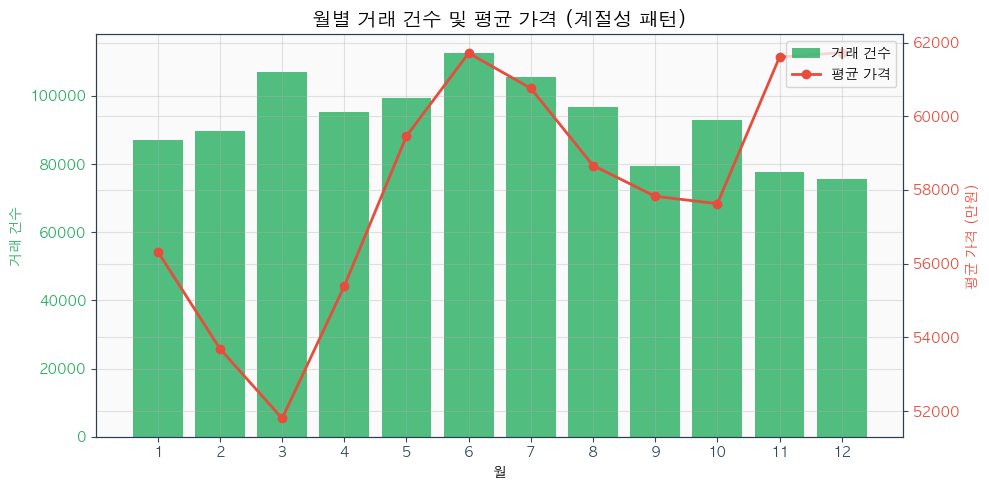

In [ ]:
# ── EDA-4b: 월별 거래 건수 및 계절성 패턴 ──
monthly = train_df.groupby("_month")["target"].agg(["count", "mean"])

fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.bar(monthly.index, monthly["count"], color=VIZ_COLORS["success"], alpha=0.8, label="거래 건수")
ax1.set_xlabel("월")
ax1.set_ylabel("거래 건수", color=VIZ_COLORS["success"])
ax1.tick_params(axis="y", labelcolor=VIZ_COLORS["success"])
ax1.set_xticks(range(1, 13))

ax2 = ax1.twinx()
ax2.plot(monthly.index, monthly["mean"], color=VIZ_COLORS["danger"], marker="o", linewidth=2, label="평균 가격")
ax2.set_ylabel("평균 가격 (만원)", color=VIZ_COLORS["danger"])
ax2.tick_params(axis="y", labelcolor=VIZ_COLORS["danger"])

ax1.set_title("월별 거래 건수 및 평균 가격 (계절성 패턴)", fontsize=14, fontweight="bold")
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc="upper right")

plt.tight_layout()
plt.show()

# 정리
train_df.drop(columns=["_year", "_month"], inplace=True)

### EDA-5. 좌표 기반 지리적 분포

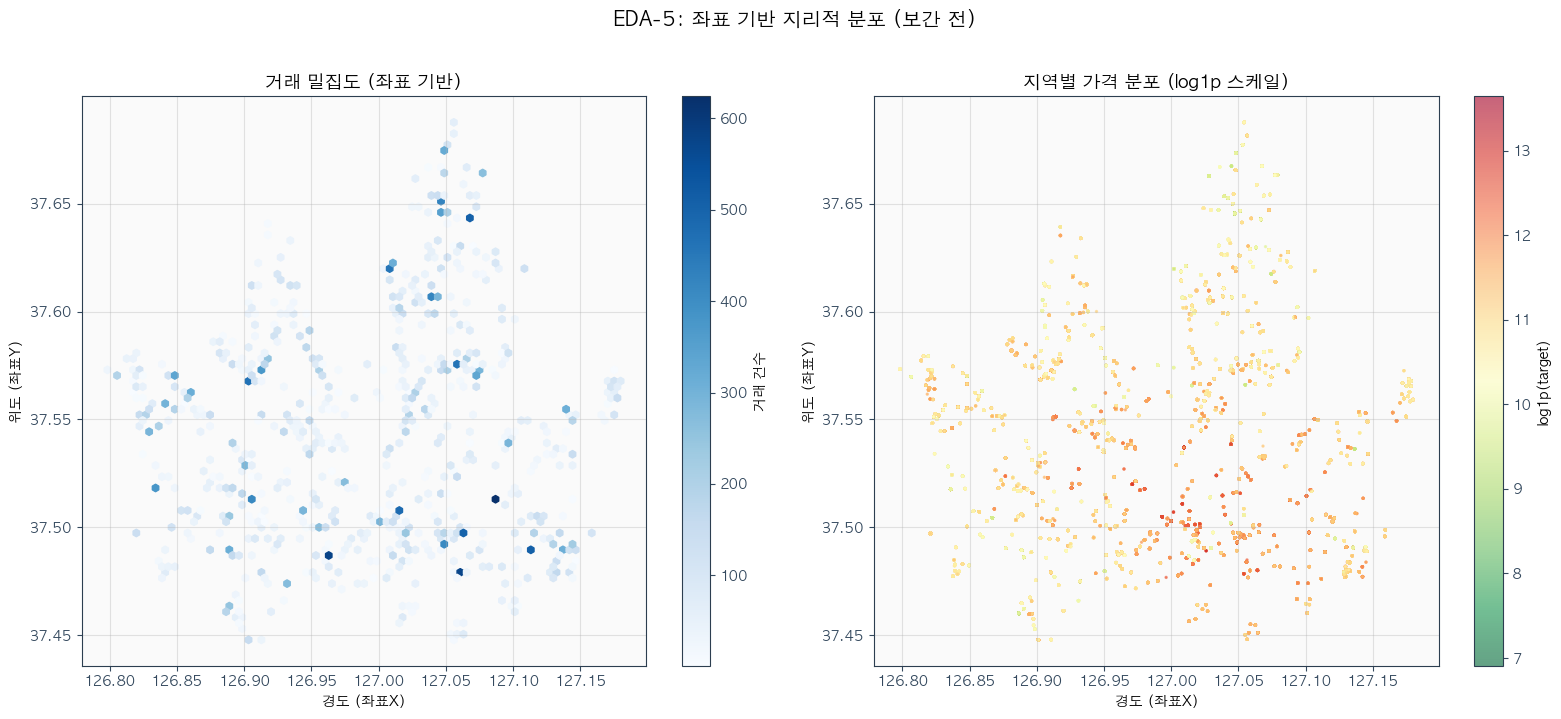

좌표 존재 행: 249,152 / 1,118,822 (22.3%)
좌표 결측 행: 869,670
→ Step 6(Kakao API + 시군구 평균)에서 결측 보간 후 전체 데이터 좌표 확보


In [ ]:
# ── EDA-5: 좌표 기반 지리적 분포 (가격 히트맵) ──
coord_valid = train_df[["좌표X", "좌표Y", "target"]].dropna()

if len(coord_valid) > 0:
    # 좌표가 있는 데이터만 샘플링 (시각화 성능)
    sample = coord_valid.sample(min(50000, len(coord_valid)), random_state=42)

    fig, axes = plt.subplots(1, 2, figsize=(16, 7))

    # 거래 밀집도
    h = axes[0].hexbin(
        sample["좌표X"], sample["좌표Y"], gridsize=80,
        cmap="Blues", mincnt=1
    )
    axes[0].set_title("거래 밀집도 (좌표 기반)", fontsize=13, fontweight="bold")
    axes[0].set_xlabel("경도 (좌표X)")
    axes[0].set_ylabel("위도 (좌표Y)")
    plt.colorbar(h, ax=axes[0], label="거래 건수")

    # 가격 분포
    sc = axes[1].scatter(
        sample["좌표X"], sample["좌표Y"],
        c=np.log1p(sample["target"]), cmap="RdYlGn_r",
        s=2, alpha=0.6
    )
    axes[1].set_title("지역별 가격 분포 (log1p 스케일)", fontsize=13, fontweight="bold")
    axes[1].set_xlabel("경도 (좌표X)")
    axes[1].set_ylabel("위도 (좌표Y)")
    plt.colorbar(sc, ax=axes[1], label="log1p(target)")

    plt.suptitle("EDA-5: 좌표 기반 지리적 분포 (보간 전)", fontsize=14, y=1.02, fontweight="bold")
    plt.tight_layout()
    plt.show()

    print(f"좌표 존재 행: {len(coord_valid):,} / {len(train_df):,} "
          f"({len(coord_valid)/len(train_df)*100:.1f}%)")
    print(f"좌표 결측 행: {len(train_df) - len(coord_valid):,}")
    print("→ Step 6(Kakao API + 시군구 평균)에서 결측 보간 후 전체 데이터 좌표 확보")
else:
    print("좌표 데이터가 없습니다.")

### EDA-6. Train / Test 분포 비교

학습 데이터와 테스트 데이터의 분포가 다르면 모델 일반화에 문제가 생길 수 있습니다.

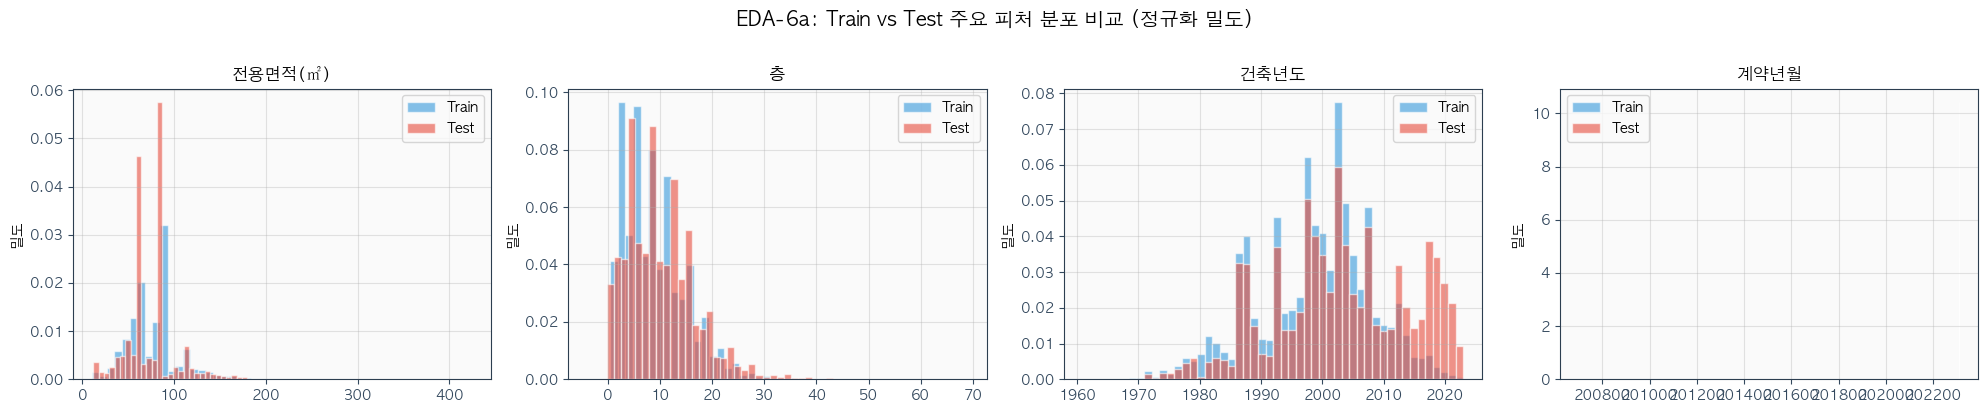

In [ ]:
# ── EDA-6a: 주요 수치형 피처 Train/Test 분포 비교 ──
compare_cols = ["전용면적(㎡)", "층", "건축년도", "계약년월"]
compare_available = [c for c in compare_cols if c in train_df.columns and c in test_df.columns]

fig, axes = plt.subplots(1, len(compare_available), figsize=(5 * len(compare_available), 4))
if len(compare_available) == 1:
    axes = [axes]

for ax, col in zip(axes, compare_available):
    ax.hist(train_df[col].dropna(), bins=50, alpha=0.6, label="Train", density=True, color=VIZ_COLORS["primary"], edgecolor="white")
    ax.hist(test_df[col].dropna(), bins=50, alpha=0.6, label="Test", density=True, color=VIZ_COLORS["danger"], edgecolor="white")
    ax.set_title(f"{col}", fontsize=12, fontweight="bold")
    ax.legend()
    ax.set_ylabel("밀도")

plt.suptitle("EDA-6a: Train vs Test 주요 피처 분포 비교 (정규화 밀도)", fontsize=14, y=1.02, fontweight="bold")
plt.tight_layout()
plt.show()

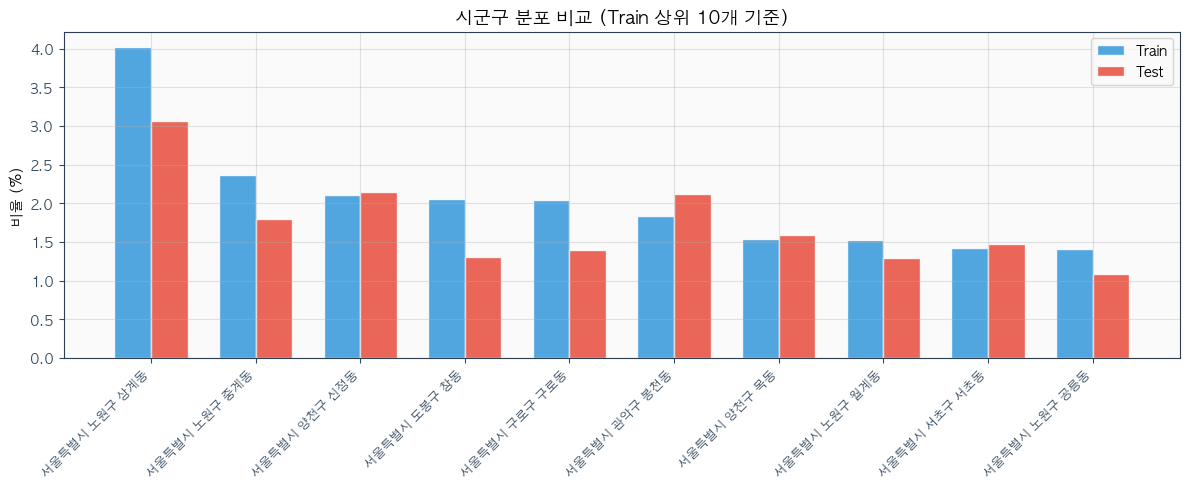

Train 시군구 수: 339
Test 시군구 수:  270
Test의 모든 시군구가 Train에 포함되어 있음


In [ ]:
# ── EDA-6b: 시군구 분포 비교 (상위 10개) ──
train_sigungu = train_df["시군구"].value_counts().head(10)
test_sigungu = test_df["시군구"].value_counts()

# 학습 데이터 상위 10개 시군구 기준으로 비교
compare_sigungu = pd.DataFrame({
    "Train (비율%)": (train_sigungu / len(train_df) * 100).round(2),
    "Test (비율%)": (test_sigungu.reindex(train_sigungu.index).fillna(0) / len(test_df) * 100).round(2),
})

fig, ax = plt.subplots(figsize=(12, 5))
x = np.arange(len(compare_sigungu))
width = 0.35
ax.bar(x - width/2, compare_sigungu["Train (비율%)"], width, label="Train", color=VIZ_COLORS["primary"], edgecolor="white", alpha=0.85)
ax.bar(x + width/2, compare_sigungu["Test (비율%)"], width, label="Test", color=VIZ_COLORS["danger"], edgecolor="white", alpha=0.85)
ax.set_xticks(x)
ax.set_xticklabels(compare_sigungu.index, rotation=45, ha="right", fontsize=9)
ax.set_title("시군구 분포 비교 (Train 상위 10개 기준)", fontsize=13, fontweight="bold")
ax.set_ylabel("비율 (%)")
ax.legend()
plt.tight_layout()
plt.show()

# 테스트에만 있는 시군구
train_sigungu_set = set(train_df["시군구"].unique())
test_sigungu_set = set(test_df["시군구"].unique())
only_test = test_sigungu_set - train_sigungu_set
print(f"Train 시군구 수: {len(train_sigungu_set):,}")
print(f"Test 시군구 수:  {len(test_sigungu_set):,}")
if only_test:
    print(f"Test에만 있는 시군구 ({len(only_test)}개): {only_test}")
else:
    print("Test의 모든 시군구가 Train에 포함되어 있음")

### EDA-7. 수치형 피처 간 상관관계 히트맵

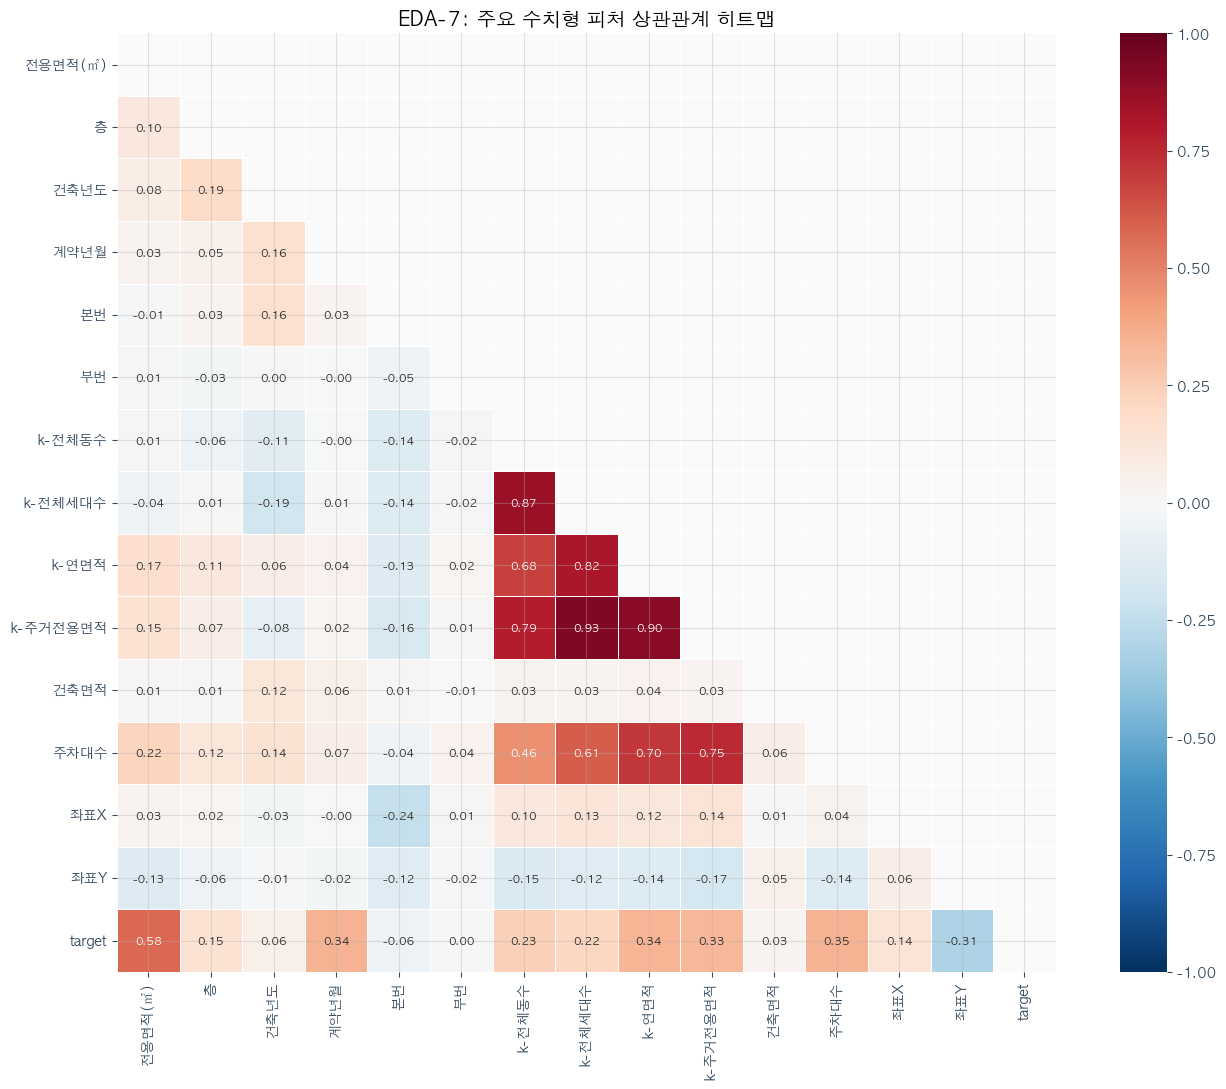

In [ ]:
# ── EDA-7: 수치형 피처 간 상관관계 히트맵 ──
# 주요 수치형 컬럼만 선택 (결측이 적은 컬럼 우선)
key_num_cols = ["전용면적(㎡)", "층", "건축년도", "계약년월", "본번", "부번",
                "k-전체동수", "k-전체세대수", "k-연면적", "k-주거전용면적",
                "건축면적", "주차대수", "좌표X", "좌표Y", "target"]
key_num_available = [c for c in key_num_cols if c in train_df.columns]

corr_matrix = train_df[key_num_available].corr()

fig, ax = plt.subplots(figsize=(14, 11))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(
    corr_matrix, mask=mask, annot=True, fmt=".2f",
    cmap="RdBu_r", center=0, vmin=-1, vmax=1,
    square=True, linewidths=0.5, ax=ax,
    annot_kws={"size": 8}, linecolor="white"
)
ax.set_title("EDA-7: 주요 수치형 피처 상관관계 히트맵", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

### EDA 요약 — 전처리 전략 수립 근거

| 발견 사항 | 전처리 전략 반영 |
|----------|---------------|
| target이 right-skewed (왜도 높음) | **log1p 변환** 적용하여 정규분포에 가깝게 |
| 가격 범위가 1,000만~200억 (4자릿수) | log 스케일 학습으로 전 가격대 균형 예측 |
| k-세대타입별 target 의미가 다름 (매매 vs 전세) | 제거하지 않고 **범주형 피처로 유지** |
| 결측 80% 이상 컬럼 다수 (해제사유발생일 등) | **80% 임계값**으로 제거, k-* 피처(60~70%)는 보존 |
| 좌표 결측 ~78% (k-* 계열과 연동) | **시군구별 평균**으로 보간 (거리 피처 계산 필수) |
| 아파트명 고유값 20,000+ | One-Hot 불가 → **Target Encoding** 적용 |
| 2020년 이후 급격한 가격 상승 | **시간 기반 샘플 가중치** + TimeSeriesSplit CV |
| 월별 계절성 패턴 존재 (봄 성수기) | **month_sin/cos** 순환 인코딩 |
| 전용면적, 층이 target과 상관관계 높음 | **교호작용 피처** (area × floor) 생성 |
| Train/Test 시군구 분포 유사 | 심각한 분포 이동 없음, 일반화 가능 |

---

---

## 2. 전처리 설정 (Configuration)

전처리에 사용할 상수와 설정값을 정의합니다.

In [ ]:
# ══════════════════════════════════════════════
# 전처리 설정
# ══════════════════════════════════════════════

# 결측 비율 임계값 (이 비율 이상인 컬럼 제거)
MISSING_THRESHOLD = 0.80

# 좌표 보존 컬럼 (고결측이어도 제거하지 않음)
COORD_PRESERVE_COLS = ["좌표X", "좌표Y"]

# 이상치 클리핑 대상 컬럼 및 IQR 배수
OUTLIER_CLIP_COLS = ["전용면적", "층", "건축년도", "주차대수", "k-전체세대수"]
OUTLIER_IQR_FACTOR = 3.0

# Target 이상치 클리핑 (퍼센타일 기반)
TARGET_LOWER_PERCENTILE = 0.001  # 하위 0.1%
TARGET_UPPER_PERCENTILE = 0.999  # 상위 99.9%

# 범주형 식별 기준
CATEGORICAL_UNIQUE_RATIO = 0.10   # 고유값 비율 < 10%
CATEGORICAL_MAX_UNIQUE = 100      # 고유값 수 < 100

# KNN Imputer 설정
KNN_N_NEIGHBORS = 5               # 이웃 수 (distance-weighted)
KNN_SAMPLE_SIZE = 30_000          # KNN 학습용 샘플 크기 (거리 계산 기준)
KNN_CHUNK_SIZE = 50_000           # 변환 시 배치 크기 (큰 배치 = 적은 오버헤드)

print("전처리 설정 완료")
print(f"  결측 임계값: {MISSING_THRESHOLD*100}%")
print(f"  IQR 이상치 배수: {OUTLIER_IQR_FACTOR}")
print(f"  Target 클리핑: {TARGET_LOWER_PERCENTILE*100}% ~ {TARGET_UPPER_PERCENTILE*100}%")
print(f"  KNN Imputer: k={KNN_N_NEIGHBORS}, 학습 샘플={KNN_SAMPLE_SIZE:,}, 배치={KNN_CHUNK_SIZE:,}")

전처리 설정 완료
  결측 임계값: 80.0%
  IQR 이상치 배수: 3.0
  Target 클리핑: 0.1% ~ 99.9%
  KNN Imputer: k=5, 학습 샘플=30,000, 배치=50,000


---

## 3-0. Step 0 — 취소 거래 필터링

`해제사유발생일`이 존재하는 행은 **취소된 거래**입니다.
이 행들은 실제 거래가 아니므로, 고결측 컬럼 제거(Step 2) 전에 **행 자체를 먼저 제거**합니다.

> **기존 방식(Step 2)과의 차이**: Step 2는 80% 결측 기준으로 *컬럼*만 삭제하지만,
> Step 0은 취소 거래 *행*을 먼저 제거하여 학습 데이터의 노이즈를 사전에 제거합니다.

In [ ]:
def filter_cancelled_transactions(df: pd.DataFrame) -> pd.DataFrame:
    """해제사유발생일이 존재하는 행(취소 거래)을 제거합니다.

    취소된 거래는 실제 유효한 거래가 아니므로, 학습 전에 제거하여
    모델이 잘못된 패턴을 학습하지 않도록 합니다.
    """
    col = "해제사유발생일"
    if col in df.columns:
        n_cancelled = df[col].notnull().sum()
        if n_cancelled > 0:
            print(f"  취소 거래 {n_cancelled:,}건 발견 → 제거")
            df = df[df[col].isnull()].copy()
        else:
            print("  취소 거래 없음")
        df = df.drop(columns=[col], errors="ignore")
    else:
        print(f"  '{col}' 컬럼 없음 — 건너뜀")
    return df


# 적용 (학습/테스트 모두)
print(f"Before: train={train_df.shape}, test={test_df.shape}")
train_df = filter_cancelled_transactions(train_df)
test_df = filter_cancelled_transactions(test_df)
print(f"After:  train={train_df.shape}, test={test_df.shape}")

Before: train=(1118822, 52), test=(9272, 51)
  취소 거래 5,983건 발견 → 제거
  취소 거래 212건 발견 → 제거
After:  train=(1112839, 51), test=(9060, 50)


---

## 3. Step 1 — Target 분리

학습 데이터에서 `target` 컬럼을 분리하여 **피처(X)**와 **타깃(y)**으로 나눕니다.
- `target`: 아파트 거래 가격 (만원 단위)
- 테스트 데이터에는 `target`이 없으므로 별도 처리 불필요

In [ ]:
# ── Step 1: Target 분리 ──
y_train = train_df["target"].copy()
X_train = train_df.drop(columns=["target"]).copy()
X_test = test_df.copy()

print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_test:  {X_test.shape}")
print(f"\ntarget 기본 통계:")
print(y_train.describe())

X_train: (1112839, 50)
y_train: (1112839,)
X_test:  (9060, 50)

target 기본 통계:
count    1.112839e+06
mean     5.776389e+04
std      4.607312e+04
min      3.500000e+02
25%      3.050000e+04
50%      4.450000e+04
75%      6.950000e+04
max      1.450000e+06
Name: target, dtype: float64


---

## 4. Step 2 — 고결측 컬럼 제거

결측 비율이 **80% 이상**인 컬럼을 자동으로 제거합니다.

| 설정 | 값 | 이유 |
|------|------|------|
| 임계값 | 80% | `k-*` 피처 보존 (60~70%대 결측) |
| 보존 컬럼 | 좌표X, 좌표Y | 버스/지하철 거리 피처 계산에 필수 |

In [ ]:
def remove_high_missing_columns(
    df: pd.DataFrame,
    threshold: float = MISSING_THRESHOLD,
    preserve_cols: list = None,
) -> pd.DataFrame:
    """결측 비율이 threshold 이상인 컬럼을 제거합니다.
    preserve_cols에 지정된 컬럼은 결측이 높아도 보존합니다.
    """
    if preserve_cols is None:
        preserve_cols = COORD_PRESERVE_COLS

    missing_ratio = df.isnull().sum() / len(df)
    cols_to_drop = missing_ratio[missing_ratio >= threshold].index.tolist()

    # 보존 컬럼은 제거 대상에서 제외
    cols_to_drop = [c for c in cols_to_drop if c not in preserve_cols]

    print(f"  제거 대상 ({len(cols_to_drop)}개): {cols_to_drop}")
    return df.drop(columns=cols_to_drop, errors="ignore")


# 적용
print("Before:", X_train.shape)
X_train = remove_high_missing_columns(X_train)
X_test = remove_high_missing_columns(X_test)
print("After:", X_train.shape)

Before: (1112839, 50)
  제거 대상 (5개): ['단지소개기존clob', 'k-135㎡초과', 'k-홈페이지', 'k-등록일자', '고용보험관리번호']
  제거 대상 (5개): ['단지소개기존clob', 'k-135㎡초과', 'k-홈페이지', 'k-등록일자', '고용보험관리번호']
After: (1112839, 45)


---

## 4-1. Step 2.5 — Float→Int64 타입 변환 (메모리 최적화)

정수형 데이터를 가진 Float 컬럼을 `Int64`(Nullable Integer)로 변환합니다.
- **반올림 후 변환**: 부동소수점 오차(예: `3.0000001`)를 안전하게 처리
- **Nullable Int64**: `NaN`을 유지하면서도 정수형으로 변환 가능

In [ ]:
# Float→Int64 변환 대상 컬럼
INT_CONVERT_COLS = [
    "본번", "부번", "k-전체동수", "k-전체세대수", "주차대수",
    "k-연면적", "k-주거전용면적", "k-관리비부과면적",
    "k-전용면적별세대현황(60㎡이하)", "k-전용면적별세대현황(60㎡~85㎡이하)",
    "k-85㎡~135㎡이하", "k-135㎡초과",
]


def convert_float_to_int(df: pd.DataFrame, cols: list = None) -> pd.DataFrame:
    """정수형 데이터를 가진 Float 컬럼을 Nullable Int64로 변환합니다."""
    if cols is None:
        cols = INT_CONVERT_COLS
    df = df.copy()
    converted = []
    for col in cols:
        if col in df.columns and df[col].dtype in ("float64", "float32"):
            try:
                df[col] = df[col].round().astype("Int64")
                converted.append(col)
            except Exception:
                pass
    print(f"  Int64 변환 완료 ({len(converted)}개): {converted}")
    return df


# 적용
print("학습 데이터 타입 변환:")
X_train = convert_float_to_int(X_train)
print("\n테스트 데이터 타입 변환:")
X_test = convert_float_to_int(X_test)

학습 데이터 타입 변환:
  Int64 변환 완료 (11개): ['본번', '부번', 'k-전체동수', 'k-전체세대수', '주차대수', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하']

테스트 데이터 타입 변환:
  Int64 변환 완료 (11개): ['본번', '부번', 'k-전체동수', 'k-전체세대수', '주차대수', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하']


---

## 5. Step 3 — 컬럼명 정리 (LightGBM 호환)

LightGBM은 컬럼명에 JSON 특수 문자(`{}[]"\\,()=`)가 포함되면 에러가 발생합니다.
정규식으로 이를 밑줄(`_`)로 치환합니다.


In [ ]:
def sanitize_column_names(df: pd.DataFrame) -> pd.DataFrame:
    """LightGBM 호환을 위해 컬럼명의 특수문자를 밑줄로 치환합니다."""
    rename_map = {}
    for col in df.columns:
        new_col = re.sub(r'[{}\[\]"\\,()=]', '_', col)
        if new_col != col:
            rename_map[col] = new_col

    if rename_map:
        print(f"  변경된 컬럼명 ({len(rename_map)}개):")
        for old, new in list(rename_map.items())[:10]:
            print(f"    {old} → {new}")
        if len(rename_map) > 10:
            print(f"    ... 외 {len(rename_map) - 10}개")
        df = df.rename(columns=rename_map)
    else:
        print("  변경할 컬럼명 없음")

    return df


# 적용
X_train = sanitize_column_names(X_train)
X_test = sanitize_column_names(X_test)

  변경된 컬럼명 (7개):
    전용면적(㎡) → 전용면적_㎡_
    k-단지분류(아파트,주상복합등등) → k-단지분류_아파트_주상복합등등_
    k-세대타입(분양형태) → k-세대타입_분양형태_
    k-건설사(시공사) → k-건설사_시공사_
    k-전용면적별세대현황(60㎡이하) → k-전용면적별세대현황_60㎡이하_
    k-전용면적별세대현황(60㎡~85㎡이하) → k-전용면적별세대현황_60㎡~85㎡이하_
    기타/의무/임대/임의=1/2/3/4 → 기타/의무/임대/임의_1/2/3/4
  변경된 컬럼명 (7개):
    전용면적(㎡) → 전용면적_㎡_
    k-단지분류(아파트,주상복합등등) → k-단지분류_아파트_주상복합등등_
    k-세대타입(분양형태) → k-세대타입_분양형태_
    k-건설사(시공사) → k-건설사_시공사_
    k-전용면적별세대현황(60㎡이하) → k-전용면적별세대현황_60㎡이하_
    k-전용면적별세대현황(60㎡~85㎡이하) → k-전용면적별세대현황_60㎡~85㎡이하_
    기타/의무/임대/임의=1/2/3/4 → 기타/의무/임대/임의_1/2/3/4


---

## 5-1. Step 3.5 — 날짜 파싱 및 주소/경과연수 파생 피처

| 피처 | 산식 | 근거 |
|------|------|------|
| `계약일자` | `계약년월 * 100 + 계약일` (YYYYMMDD 정수) | 시계열 정렬 및 시간 피처 |
| `구` | 시군구 → 2번째 토큰 | 구 단위 위치 정보 |
| `동` | 시군구 → 3번째 토큰 | 동 단위 위치 정보 |
| `건물나이` | `계약연도 − 건축년도` | 경과연수 피처 |

In [ ]:
def add_date_address_features(df: pd.DataFrame) -> pd.DataFrame:
    """날짜 파싱, 주소 분리, 경과연수 등 파생 피처를 생성합니다."""
    df = df.copy()
    created = []

    # 1) 계약일자: 계약년월(202301) + 계약일(15) → 20230115 (정수)
    if "계약년월" in df.columns and "계약일" in df.columns:
        df["계약일자"] = (
            df["계약년월"].astype(str)
            + df["계약일"].astype(str).str.zfill(2)
        ).astype("Int64")
        created.append("계약일자")

    # 2) 시군구 → 구, 동 분리
    if "시군구" in df.columns:
        split = df["시군구"].str.split(" ", expand=True)
        if split.shape[1] >= 2:
            df["구"] = split[1]
            created.append("구")
        if split.shape[1] >= 3:
            df["동"] = split[2]
            created.append("동")

    # 3) 건물나이 (경과연수)
    if "건축년도" in df.columns and "계약년월" in df.columns:
        contract_year = df["계약년월"] // 100
        df["건물나이"] = contract_year - df["건축년도"]
        # 음수(미래 건축) → 0으로 클리핑
        df["건물나이"] = df["건물나이"].clip(lower=0)
        created.append("건물나이")

    print(f"  생성된 파생 피처 ({len(created)}개): {created}")
    return df


# 적용
print("학습 데이터 날짜/주소 파생:")
X_train = add_date_address_features(X_train)
print(f"\n테스트 데이터 날짜/주소 파생:")
X_test = add_date_address_features(X_test)
print(f"\n현재 컬럼 수: X_train={X_train.shape[1]}, X_test={X_test.shape[1]}")

학습 데이터 날짜/주소 파생:
  생성된 파생 피처 (4개): ['계약일자', '구', '동', '건물나이']

테스트 데이터 날짜/주소 파생:
  생성된 파생 피처 (4개): ['계약일자', '구', '동', '건물나이']

현재 컬럼 수: X_train=49, X_test=49


---

## 6. Step 4 — 범주형 컬럼 식별

두 가지 기준으로 범주형 컬럼을 자동 식별합니다:

| 조건 | 대상 |
|------|------|
| `dtype == object` | 문자열 컬럼 (시군구, 아파트명 등) |
| 고유값 비율 < 10% **AND** 고유값 수 < 100 | 숫자형이지만 실질적으로 범주인 컬럼 |

In [ ]:
def identify_categorical_columns(
    df: pd.DataFrame,
    exclude_cols: list = None,
    unique_ratio: float = CATEGORICAL_UNIQUE_RATIO,
    max_unique: int = CATEGORICAL_MAX_UNIQUE,
) -> list:
    """범주형 컬럼을 자동 식별합니다.

    1) dtype이 object인 컬럼
    2) 수치형이지만 고유값 비율이 unique_ratio 미만이고 고유값 수가 max_unique 미만인 컬럼
    """
    if exclude_cols is None:
        exclude_cols = []

    categorical_cols = []
    n = len(df)

    for col in df.columns:
        if col in exclude_cols:
            continue

        # 1) object 타입
        if df[col].dtype == object:
            categorical_cols.append(col)
            continue

        # 2) 수치형이지만 실질적 범주형
        nunique = df[col].nunique()
        if n > 0 and (nunique / n) < unique_ratio and nunique < max_unique:
            categorical_cols.append(col)

    return categorical_cols


categorical_cols = identify_categorical_columns(X_train)
print(f"식별된 범주형 컬럼 ({len(categorical_cols)}개):")
for i, col in enumerate(categorical_cols, 1):
    nunique = X_train[col].nunique()
    dtype = X_train[col].dtype
    # Ensure values are strings before applying format specifiers to avoid TypeError
    print(f"  {i:2d}. {str(col):<35s} | dtype={str(dtype):<10s} | 고유값={int(nunique):,}")

식별된 범주형 컬럼 (20개):
   1. 계약일                                 | dtype=int64      | 고유값=31
   2. 층                                   | dtype=int64      | 고유값=73
   3. 건축년도                                | dtype=int64      | 고유값=60
   4. 거래유형                                | dtype=str        | 고유값=3
   5. k-단지분류_아파트_주상복합등등_                  | dtype=str        | 고유값=5
   6. k-전화번호                              | dtype=object     | 고유값=1,079
   7. k-팩스번호                              | dtype=object     | 고유값=1,358
   8. k-세대타입_분양형태_                        | dtype=str        | 고유값=3
   9. k-관리방식                              | dtype=str        | 고유값=3
  10. k-복도유형                              | dtype=str        | 고유값=5
  11. k-난방방식                              | dtype=str        | 고유값=4
  12. k-전체동수                              | dtype=Int64      | 고유값=41
  13. 경비비관리형태                             | dtype=str        | 고유값=4
  14. 세대전기계약방법                            | dtype=str        | 고유값=2
  15

---

## 7. Step 5 — 결측 지표 피처 생성

각 행의 결측값 총 개수를 새로운 피처(`missing_count`)로 생성합니다.

> 결측 자체가 정보를 담고 있는 경우(예: 오래된 아파트일수록 `k-*` 피처가 비어 있음)를 모델이 학습할 수 있게 합니다.

In [ ]:
# ── Step 5: 결측 지표 피처 ──
X_train["missing_count"] = X_train.isnull().sum(axis=1)
X_test["missing_count"] = X_test.isnull().sum(axis=1)

print("missing_count 분포 (학습 데이터):")
print(X_train["missing_count"].value_counts().sort_index().head(20))
print(f"\n평균 결측 수: {X_train['missing_count'].mean():.2f}")
print(f"최대 결측 수: {X_train['missing_count'].max()}")

missing_count 분포 (학습 데이터):
missing_count
0     233415
1      11472
2        993
3        215
4       1009
6        577
7        133
9        107
31    862743
32      2100
34        75
Name: count, dtype: int64

평균 결측 수: 24.12
최대 결측 수: 34


---

## 8. Step 6 — 좌표 결측 보간

좌표가 비어 있는 행을 다음 순서로 보간합니다.

1. **Kakao API** (주소→좌표): `KAKAO_API_KEY`가 설정된 경우, 시군구·도로명·번지·아파트명으로 주소를 구성해 Kakao 주소 검색 API를 호출하고, 고유 주소별로 1회만 호출하여 좌표를 채웁니다.
2. **시군구별 평균**: API 미설정 또는 실패 시 시군구별 평균 좌표로 보간합니다.
3. **전체 평균**: 시군구 정보가 없는 경우 전체 평균을 사용합니다.

> **환경변수**: `KAKAO_API_KEY`를 설정하면 API 기반 보간이 활성화됩니다. `.env` 파일 또는 `python-dotenv`로 로드 가능합니다.
>
> **학습/테스트 일관성**: 학습 데이터에서 계산한 시군구별 평균 좌표를 `train_stats`에 저장하고, 테스트 전처리 시 동일한 값을 사용합니다.

In [ ]:
# ── Step 6: 좌표 결측 보간 (Kakao API + 시군구 평균 Fallback) ──

import time
import urllib.request
import urllib.parse
import json as _json

# train_stats: 학습 데이터 기준 통계를 저장 (테스트 전처리 시 재사용)
train_stats = {}

# Kakao API 키 (환경변수 KAKAO_API_KEY 또는 .env 로드)
try:
    from dotenv import load_dotenv
    load_dotenv()  # 프로젝트 루트의 .env 자동 탐색
except ImportError:
    pass
KAKAO_API_KEY = os.environ.get("KAKAO_API_KEY", "")
if not KAKAO_API_KEY:
    print("KAKAO_API_KEY 미설정: 좌표 보간이 시군구/전체 평균만 사용됩니다. (Kakao API 스킵)")


def _build_address(row: pd.Series) -> str:
    """row에서 좌표 조회용 주소 문자열을 생성합니다."""
    parts = []
    if pd.notna(row.get("시군구")) and str(row["시군구"]).strip():
        parts.append(str(row["시군구"]).strip())
    if pd.notna(row.get("도로명")) and str(row["도로명"]).strip():
        parts.append(str(row["도로명"]).strip())
    elif pd.notna(row.get("번지")) and str(row["번지"]).strip():
        parts.append(str(row["번지"]).strip())
    elif pd.notna(row.get("본번")):
        try:
            b = str(int(row["본번"]))
            s = str(int(row["부번"])) if pd.notna(row.get("부번")) else ""
            parts.append(f"{b}-{s}" if s else b)
        except (ValueError, TypeError):
            pass
    if pd.notna(row.get("아파트명")) and str(row["아파트명"]).strip():
        parts.append(str(row["아파트명"]).strip())
    return " ".join(parts) if parts else ""


def _fetch_coords_from_kakao(address: str, api_key: str, cache: dict, delay_sec: float = 0.15) -> tuple[float, float] | None:
    """Kakao 주소 검색 API로 주소→좌표 변환. 캐시 활용, rate limit 적용."""
    if not address or not api_key.strip():
        return None
    address = address.strip()
    if address in cache:
        return cache[address]
    try:
        url = "https://dapi.kakao.com/v2/local/search/address.json?" + urllib.parse.urlencode({"query": address})
        req = urllib.request.Request(url, headers={"Authorization": f"KakaoAK {api_key}"})
        with urllib.request.urlopen(req, timeout=5) as resp:
            data = _json.loads(resp.read().decode())
        docs = data.get("documents", [])
        if docs and docs[0].get("x") and docs[0].get("y"):
            x, y = float(docs[0]["x"]), float(docs[0]["y"])
            cache[address] = (x, y)
            return (x, y)
    except Exception:
        pass
    cache[address] = None
    time.sleep(delay_sec)
    return None


def interpolate_coordinates(
    df: pd.DataFrame,
    region_col: str = "시군구",
    coord_cols: list = None,
    stats: dict = None,
    use_kakao_api: bool = True,
    kakao_delay_sec: float = 0.15,
) -> tuple:
    """좌표 결측을 1) Kakao API 주소→좌표, 2) 시군구별 평균, 3) 전체 평균 순으로 보간합니다.

    use_kakao_api: True일 때 KAKAO_API_KEY가 있으면 주소 기반 좌표 조회 시도
    Returns:
        (df, coord_group_means, coord_global_means)
    """
    if coord_cols is None:
        coord_cols = ["좌표X", "좌표Y"]

    df = df.copy()
    coord_group_means = {}
    coord_global_means = {}
    kakao_cache = {} if use_kakao_api and KAKAO_API_KEY else None

    # 1단계: Kakao API로 주소→좌표 보간 (결측 행만, 고유 주소별 1회 호출)
    if use_kakao_api and KAKAO_API_KEY and "좌표X" in df.columns and "좌표Y" in df.columns:
        missing_both = df["좌표X"].isna() & df["좌표Y"].isna()
        if missing_both.any():
            addr_series = df.loc[missing_both].apply(_build_address, axis=1)
            unique_addr = addr_series[addr_series.str.len() > 0].unique()
            addr_to_coord = {}
            for addr in tqdm(unique_addr, desc="Kakao API 주소→좌표 조회", leave=False):
                r = _fetch_coords_from_kakao(addr, KAKAO_API_KEY, kakao_cache, 0)
                if r:
                    addr_to_coord[addr] = r
                time.sleep(kakao_delay_sec)
            coords = addr_series.map(addr_to_coord)
            valid_idx = coords.dropna().index
            if len(valid_idx) > 0:
                df.loc[valid_idx, "좌표X"] = coords.loc[valid_idx].apply(lambda c: c[0])
                df.loc[valid_idx, "좌표Y"] = coords.loc[valid_idx].apply(lambda c: c[1])
                print(f"  Kakao API: {len(valid_idx):,}건 보간")

    for coord in coord_cols:
        if coord not in df.columns:
            continue

        before_na = df[coord].isna().sum()

        if stats is not None:
            group_mean = stats.get("coord_group_means", {}).get(coord, {})
            global_mean = stats.get("coord_global_means", {}).get(coord, df[coord].mean())
            if region_col in df.columns and group_mean:
                df[coord] = df[coord].fillna(df[region_col].map(group_mean))
            df[coord] = df[coord].fillna(global_mean)
        else:
            global_mean = df[coord].mean()
            coord_global_means[coord] = global_mean
            if region_col in df.columns:
                group_means = df.groupby(region_col)[coord].mean()
                coord_group_means[coord] = group_means.to_dict()
                df[coord] = df[coord].fillna(df[region_col].map(group_means))
            df[coord] = df[coord].fillna(global_mean)

        after_na = df[coord].isna().sum()
        print(f"  {coord}: 결측 {before_na:,} → {after_na:,} (보간: {before_na - after_na:,}건)")

    return df, coord_group_means, coord_global_means


# 학습 데이터 좌표 보간
coord_missing_before = (X_train["좌표X"].isna() | X_train["좌표Y"].isna()).sum()
print("학습 데이터 좌표 보간:")
X_train, coord_group_means, coord_global_means = interpolate_coordinates(X_train)
coord_missing_after = (X_train["좌표X"].isna() | X_train["좌표Y"].isna()).sum()
train_stats["coord_group_means"] = coord_group_means
train_stats["coord_global_means"] = coord_global_means

# 테스트 데이터 좌표 보간 (학습 기준 통계 사용)
print("\n테스트 데이터 좌표 보간 (학습 기준 통계 사용):")
X_test, _, _ = interpolate_coordinates(X_test, stats=train_stats)

KAKAO_API_KEY 미설정: 좌표 보간이 시군구/전체 평균만 사용됩니다. (Kakao API 스킵)
학습 데이터 좌표 보간:
  좌표X: 결측 865,025 → 0 (보간: 865,025건)
  좌표Y: 결측 865,025 → 0 (보간: 865,025건)

테스트 데이터 좌표 보간 (학습 기준 통계 사용):
  좌표X: 결측 6,414 → 0 (보간: 6,414건)
  좌표Y: 결측 6,414 → 0 (보간: 6,414건)


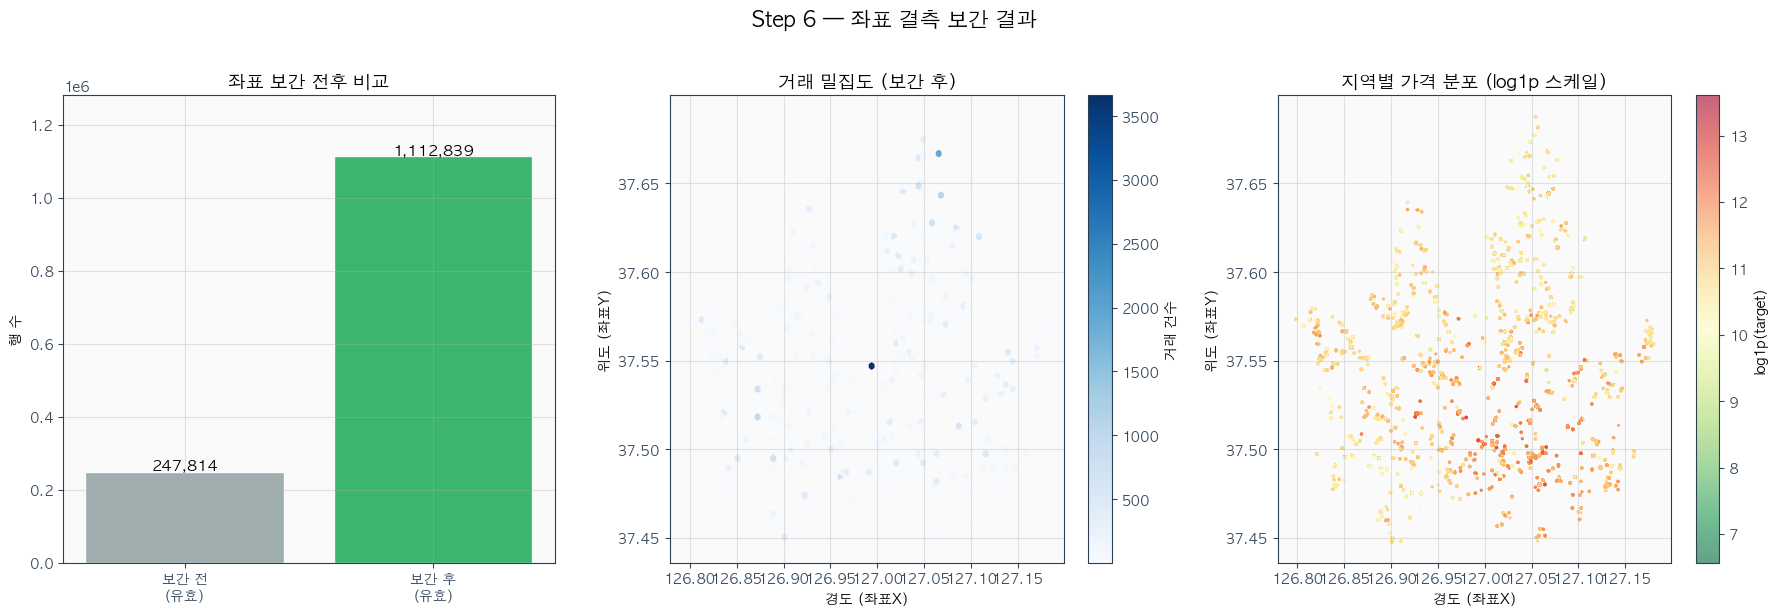

보간 전 결측: 865,025건 → 보간 후 유효: 1,112,839건 (100.0%)


In [ ]:
# ── Step 6 시각화: 좌표 보간 전후 비교 및 지리적 분포 ──
plot_df = X_train[["좌표X", "좌표Y"]].copy()
plot_df["target"] = y_train.values
plot_df = plot_df.dropna()

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1) 좌표 보간 전후 비교 (유효 건수)
valid_before = len(X_train) - coord_missing_before
valid_after = len(X_train) - coord_missing_after
ax1 = axes[0]
bars = ax1.bar(
    ["보간 전\n(유효)", "보간 후\n(유효)"],
    [valid_before, valid_after],
    color=[VIZ_COLORS["gray"], VIZ_COLORS["success"]],
    edgecolor="white",
    alpha=0.9,
)
ax1.set_title("좌표 보간 전후 비교", fontsize=13, fontweight="bold")
ax1.set_ylabel("행 수")
for b in bars:
    h = b.get_height()
    ax1.text(b.get_x() + b.get_width() / 2, h + 5000, f"{int(h):,}", ha="center", fontsize=11)
ax1.set_ylim(0, max(valid_before, valid_after) * 1.15)

# 2) 거래 밀집도 (보간 후 전체)
sample = plot_df.sample(min(50000, len(plot_df)), random_state=42)
h = axes[1].hexbin(
    sample["좌표X"], sample["좌표Y"], gridsize=80,
    cmap="Blues", mincnt=1
)
axes[1].set_title("거래 밀집도 (보간 후)", fontsize=13, fontweight="bold")
axes[1].set_xlabel("경도 (좌표X)")
axes[1].set_ylabel("위도 (좌표Y)")
plt.colorbar(h, ax=axes[1], label="거래 건수")

# 3) 지역별 가격 분포 (log1p 스케일)
sc = axes[2].scatter(
    sample["좌표X"], sample["좌표Y"],
    c=np.log1p(sample["target"]), cmap="RdYlGn_r",
    s=2, alpha=0.6
)
axes[2].set_title("지역별 가격 분포 (log1p 스케일)", fontsize=13, fontweight="bold")
axes[2].set_xlabel("경도 (좌표X)")
axes[2].set_ylabel("위도 (좌표Y)")
plt.colorbar(sc, ax=axes[2], label="log1p(target)")

plt.suptitle("Step 6 — 좌표 결측 보간 결과", fontsize=15, y=1.02, fontweight="bold")
plt.tight_layout()
plt.show()
print(f"보간 전 결측: {coord_missing_before:,}건 → 보간 후 유효: {len(plot_df):,}건 ({len(plot_df)/len(X_train)*100:.1f}%)")

---

## 9. Step 7 — 결측값 대체 (KNN Imputer + GPU 가속)

원격 GPU 서버에 `cuml`(RAPIDS)이 설치되어 있으면 **GPU 가속 KNN**을 자동으로 사용합니다.
설치되지 않은 경우 `sklearn` CPU 버전으로 폴백합니다.

| 유형 | 처리 방식 | 비고 |
|------|----------|------|
| **범주형** | `"미상"` 문자열로 대체 | 모델이 결측 자체를 하나의 범주로 학습 |
| **수치형** | **KNN Imputer** (k=5, distance-weighted) | 유사한 데이터 포인트의 가중 평균으로 결측 보간 |

### KNN Imputer 핵심 원리

1. 결측값이 있는 행에 대해, **결측이 아닌 피처들의 유클리드 거리**를 기반으로 가장 가까운 k개 이웃을 탐색
2. 이웃들의 해당 피처 값을 **거리 역수 가중 평균**(weights='distance')으로 계산하여 결측 보간
3. 단순 중앙값/평균 대체보다 **피처 간 상관관계를 반영**하여 더 정교한 결측 복원 가능

### 대용량 처리 전략 (성능 최적화)

| 최적화 | 내용 | 효과 |
|--------|------|------|
| **완전 행 스킵** | 결측이 없는 ~235K행은 KNN 변환 건너뜀 | 처리량 ~21% 절감 |
| **샘플 학습** | 30,000건으로 fit (전체 1.1M 대신) | fit 시간 대폭 단축 |
| **큰 배치** | 50,000건씩 transform | 배치 오버헤드 최소화 |
| **학습/테스트 일관성** | 학습에서 fit한 imputer를 테스트에 재사용 | 데이터 누수 방지 |

---

## 9.5 파생 피처: 세대당 주차대수 (parking_per_household)

서울 아파트에서 **주차대수**는 단지 규모와 편의성을 반영하는 중요한 변수입니다.
단순 주차대수보다 **세대당 주차 비율**이 더 유의미한 피처입니다.

| 피처 | 산식 | 의미 |
|------|------|------|
| `parking_per_household` | `주차대수 / k-전체세대수` | 세대당 주차 대수 비율 |

> **주의**: `dropna()`로 데이터를 제거하지 않고, 결측이나 0인 경우 `fillna(0)`으로 안전하게 처리합니다.
> - `k-전체세대수`가 0 또는 NaN → 분모에 소량(1e-6) 추가하여 division by zero 방지
> - 계산 결과가 NaN → `fillna(0)`으로 대체

In [ ]:
# ── 파생 피처: 세대당 주차대수 ──
# dropna를 사용하지 않고, 결측/0 값을 fillna로 안전하게 처리

def add_parking_per_household(df: pd.DataFrame) -> pd.DataFrame:
    """주차대수 / k-전체세대수 = 세대당 주차대수 피처를 생성합니다.
    
    - dropna 미사용: 데이터 제거 없이 결측을 fillna(0)으로 처리
    - division by zero 방지: 분모에 1e-6 추가
    """
    df = df.copy()
    parking_col = "주차대수"
    household_col = "k-전체세대수"
    
    if parking_col in df.columns and household_col in df.columns:
        # 결측은 0으로 대체 (dropna 대신 fillna 사용)
        parking = df[parking_col].fillna(0)
        household = df[household_col].fillna(0)
        
        # division by zero 방지 (세대수가 0인 경우 대비)
        df["parking_per_household"] = parking / (household + 1e-6)
        
        # 혹시 남은 NaN/inf 처리
        df["parking_per_household"] = df["parking_per_household"].replace(
            [np.inf, -np.inf], 0
        ).fillna(0)
        
        print(f"  parking_per_household 피처 생성 완료")
        print(f"    주차대수 결측:    {df[parking_col].isna().sum():,}건 → fillna(0)")
        print(f"    k-전체세대수 결측: {df[household_col].isna().sum():,}건 → fillna(0)")
        print(f"    결과 통계: mean={df['parking_per_household'].mean():.4f}, "
              f"median={df['parking_per_household'].median():.4f}, "
              f"max={df['parking_per_household'].max():.4f}")
    else:
        missing = [c for c in [parking_col, household_col] if c not in df.columns]
        print(f"  parking_per_household 건너뜀 — 컬럼 없음: {missing}")
    
    return df


# 학습 데이터
print("학습 데이터:")
X_train = add_parking_per_household(X_train)

# 테스트 데이터
print("\n테스트 데이터:")
X_test = add_parking_per_household(X_test)

print(f"\n현재 컬럼 수: X_train={X_train.shape[1]}, X_test={X_test.shape[1]}")

학습 데이터:
  parking_per_household 피처 생성 완료
    주차대수 결측:    865,067건 → fillna(0)
    k-전체세대수 결측: 864,918건 → fillna(0)
    결과 통계: mean=0.2224, median=0.0000, max=3.8375

테스트 데이터:
  parking_per_household 피처 생성 완료
    주차대수 결측:    6,415건 → fillna(0)
    k-전체세대수 결측: 6,414건 → fillna(0)
    결과 통계: mean=0.3093, median=0.0000, max=2.9040

현재 컬럼 수: X_train=51, X_test=51


---

## 10. Step 8 — 이상치 클리핑

### 10.1 수치형 피처 이상치 (IQR × 3.0)

주요 수치형 피처에 IQR 기반 클리핑을 적용합니다.
- `factor=3.0`으로 설정하여 극단적 오류 데이터만 제거
- 정상 범위의 분산은 최대한 보존

In [ ]:
def clip_outliers(
    df: pd.DataFrame,
    columns: list,
    method: str = "iqr",
    factor: float = OUTLIER_IQR_FACTOR,
) -> pd.DataFrame:
    """IQR 기반으로 수치형 컬럼의 이상치를 클리핑합니다.

    lower = Q1 - factor * IQR
    upper = Q3 + factor * IQR
    """
    df = df.copy()
    total_clipped = 0

    for col in columns:
        if col not in df.columns:
            print(f"  {col}: 컬럼 없음 — 건너뜀")
            continue

        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - factor * IQR
        upper = Q3 + factor * IQR

        n_below = (df[col] < lower).sum()
        n_above = (df[col] > upper).sum()
        n_clipped = n_below + n_above

        df[col] = df[col].clip(lower=lower, upper=upper)

        if n_clipped > 0:
            print(f"  {col}: 클리핑 {n_clipped:,}건 "
                  f"(하한={lower:.2f}, 상한={upper:.2f}, "
                  f"아래={n_below:,}, 위={n_above:,})")
        total_clipped += n_clipped

    print(f"  총 클리핑: {total_clipped:,}건")
    return df


# 학습 데이터 이상치 클리핑
print("수치형 이상치 클리핑 (학습 데이터):")
X_train = clip_outliers(X_train, OUTLIER_CLIP_COLS)

수치형 이상치 클리핑 (학습 데이터):
  전용면적: 컬럼 없음 — 건너뜀
  층: 클리핑 1,779건 (하한=-20.00, 상한=36.00, 아래=0, 위=1,779)
  주차대수: 클리핑 11,837건 (하한=-2570.00, 상한=4157.00, 아래=0, 위=11,837)
  k-전체세대수: 클리핑 3,480건 (하한=-3254.00, 상한=5279.00, 아래=0, 위=3,480)
  총 클리핑: 17,096건


### 10.2 Target 이상치 (퍼센타일 기반)

초기에는 IQR ×2.0으로 Target을 클리핑했으나 예측 범위가 지나치게 압축되어 RMSE가 악화되었습니다.
이를 **퍼센타일 0.1%~99.9%** 방식으로 완화하여 극단적 오류만 제거합니다.

| 방식 | 제거 대상 | RMSE 영향 |
|------|----------|-----------|
| IQR ×2.0 (초기) | 약 3~5% 데이터 | 예측 범위 압축 → RMSE 악화 |
| **퍼센타일 0.1%~99.9% (최종)** | 약 0.2% 데이터 | 극단값만 제거 → RMSE 개선 |

Target 클리핑 범위: [7,900, 428,000] (만원)
  하위 0.1% 이하: 1,074건
  상위 99.9% 이상: 1,106건
  총 클리핑: 2,180건 (0.196%)


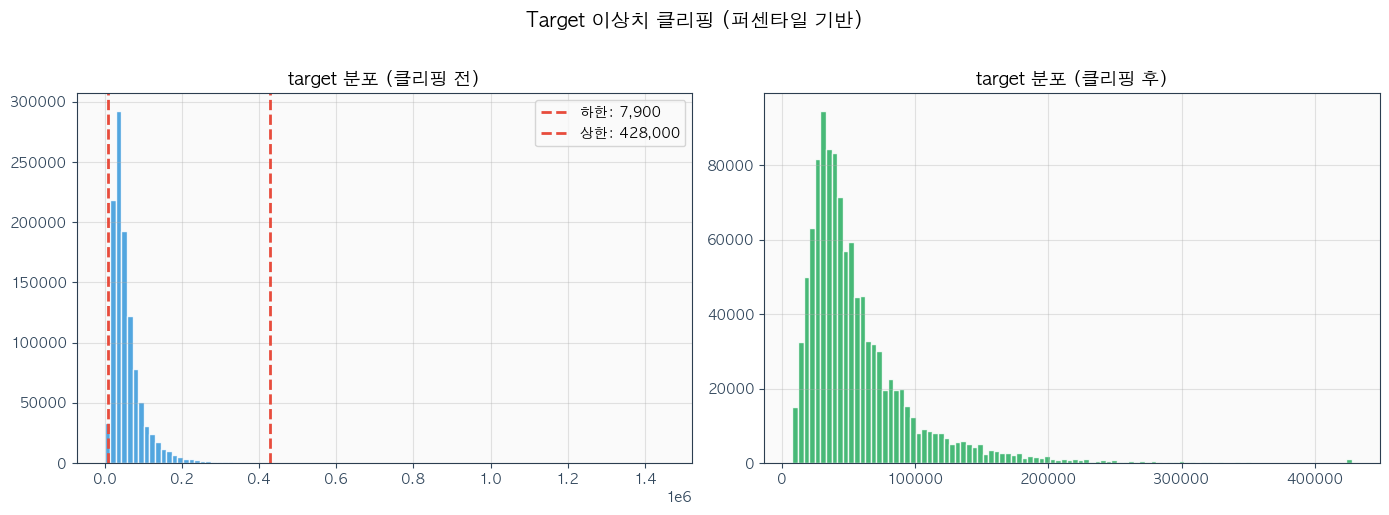

In [ ]:
# ── Target 이상치 클리핑 (퍼센타일 기반) ──
lower_pct = y_train.quantile(TARGET_LOWER_PERCENTILE)
upper_pct = y_train.quantile(TARGET_UPPER_PERCENTILE)

n_below = (y_train < lower_pct).sum()
n_above = (y_train > upper_pct).sum()

print(f"Target 클리핑 범위: [{lower_pct:,.0f}, {upper_pct:,.0f}] (만원)")
print(f"  하위 {TARGET_LOWER_PERCENTILE*100}% 이하: {n_below:,}건")
print(f"  상위 {TARGET_UPPER_PERCENTILE*100}% 이상: {n_above:,}건")
print(f"  총 클리핑: {n_below + n_above:,}건 ({(n_below + n_above) / len(y_train) * 100:.3f}%)")

y_train = y_train.clip(lower=lower_pct, upper=upper_pct)

# 클리핑 전후 비교
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].hist(train_df["target"], bins=100, color=VIZ_COLORS["primary"], edgecolor="white", alpha=0.85)
axes[0].set_title("target 분포 (클리핑 전)", fontsize=13, fontweight="bold")
axes[0].axvline(lower_pct, color=VIZ_COLORS["danger"], linestyle="--", linewidth=2, label=f"하한: {lower_pct:,.0f}")
axes[0].axvline(upper_pct, color=VIZ_COLORS["danger"], linestyle="--", linewidth=2, label=f"상한: {upper_pct:,.0f}")
axes[0].legend()

axes[1].hist(y_train, bins=100, color=VIZ_COLORS["success"], edgecolor="white", alpha=0.85)
axes[1].set_title("target 분포 (클리핑 후)", fontsize=13, fontweight="bold")

plt.suptitle("Target 이상치 클리핑 (퍼센타일 기반)", fontsize=14, y=1.02, fontweight="bold")
plt.tight_layout()
plt.show()

---

## 11. Step 9 — Target 로그 변환

아파트 가격은 **우측으로 꼬리가 긴 분포(right-skewed)**를 보이므로 `log1p` 변환으로 정규분포에 가깝게 만듭니다.

| 변환 | 학습 시 | RMSE 계산 | 효과 |
|------|--------|-----------|------|
| 없음 | 원본 가격으로 학습 | 고가 아파트 오차가 지배적 | 저가 아파트 예측 부정확 |
| **log1p** | 로그 스케일로 학습 | 비율 기반 오차 학습 | 전 가격대에서 균형 잡힌 예측 |

> 예측 시에는 `expm1`으로 역변환하여 원래 가격 스케일로 복원합니다.

변환 전 - 범위: [7,900, 428,000]
변환 후 - 범위: [8.9747, 12.9669]
변환 전 왜도: 2.9014
변환 후 왜도: 0.2841

역변환 최대 오차: 0.0000000003 (0에 가까울수록 정확)


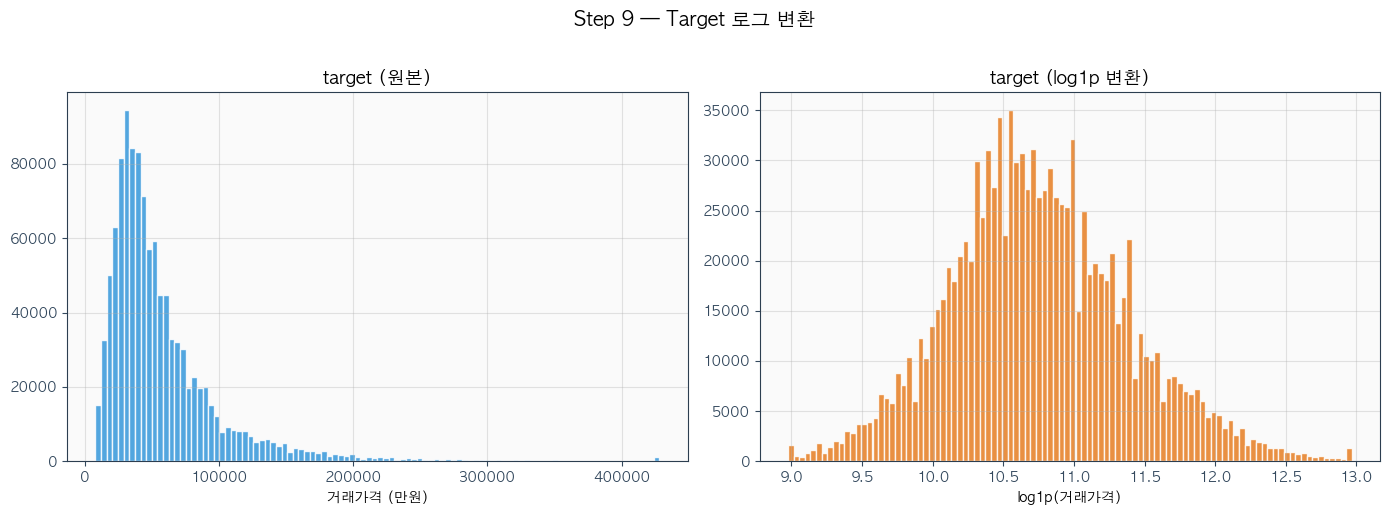

In [ ]:
def log_transform_target(y: pd.Series) -> pd.Series:
    """Target에 log1p 변환을 적용합니다."""
    return np.log1p(y)


def inverse_log_transform(y_log: np.ndarray) -> np.ndarray:
    """log1p 변환을 역변환합니다 (예측 시 사용)."""
    return np.expm1(y_log)


# ── 로그 변환 적용 ──
y_train_log = log_transform_target(y_train)

print(f"변환 전 - 범위: [{y_train.min():,.0f}, {y_train.max():,.0f}]")
print(f"변환 후 - 범위: [{y_train_log.min():.4f}, {y_train_log.max():.4f}]")
print(f"변환 전 왜도: {y_train.skew():.4f}")
print(f"변환 후 왜도: {y_train_log.skew():.4f}")

# 역변환 검증
y_restored = inverse_log_transform(y_train_log.values)
max_error = np.max(np.abs(y_train.values - y_restored))
print(f"\n역변환 최대 오차: {max_error:.10f} (0에 가까울수록 정확)")

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(y_train, bins=100, color=VIZ_COLORS["primary"], edgecolor="white", alpha=0.85)
axes[0].set_title("target (원본)", fontsize=13, fontweight="bold")
axes[0].set_xlabel("거래가격 (만원)")

axes[1].hist(y_train_log, bins=100, color=VIZ_COLORS["secondary"], edgecolor="white", alpha=0.85)
axes[1].set_title("target (log1p 변환)", fontsize=13, fontweight="bold")
axes[1].set_xlabel("log1p(거래가격)")

plt.suptitle("Step 9 — Target 로그 변환", fontsize=14, y=1.02, fontweight="bold")
plt.tight_layout()
plt.show()

---

## 12. 전처리 결과 검증 및 요약

In [ ]:
# ══════════════════════════════════════════════
# 전처리 결과 요약
# ══════════════════════════════════════════════

print("=" * 60)
print("전처리 완료 — 최종 결과 요약")
print("=" * 60)

print(f"\n[데이터 형상]")
print(f"  X_train:     {X_train.shape}")
print(f"  y_train_log: {y_train_log.shape}")
print(f"  X_test:      {X_test.shape}")

# 결측 확인
train_na = X_train.isnull().sum().sum()
test_na = X_test.isnull().sum().sum()
print(f"\n[잔여 결측]")
print(f"  X_train: {train_na:,}건")
print(f"  X_test:  {test_na:,}건")

# 수치형 / 범주형 비율
num_cols = X_train.select_dtypes(include=[np.number]).columns
cat_cols_final = [c for c in categorical_cols if c in X_train.columns]
print(f"\n[컬럼 구성]")
print(f"  수치형: {len(num_cols)}개")
print(f"  범주형: {len(cat_cols_final)}개")
print(f"  전체:   {len(X_train.columns)}개")

# train_stats 확인
print(f"\n[학습 기준 통계 (train_stats)]")
for key, val in train_stats.items():
    if isinstance(val, dict):
        print(f"  {key}: {len(val)}개 항목")
    else:
        print(f"  {key}: {type(val).__name__}")

전처리 완료 — 최종 결과 요약

[데이터 형상]
  X_train:     (1112839, 51)
  y_train_log: (1112839,)
  X_test:      (9060, 51)

[잔여 결측]
  X_train: 25,108,228건
  X_test:  186,253건

[컬럼 구성]
  수치형: 23개
  범주형: 20개
  전체:   51개

[학습 기준 통계 (train_stats)]
  coord_group_means: 2개 항목
  coord_global_means: 2개 항목


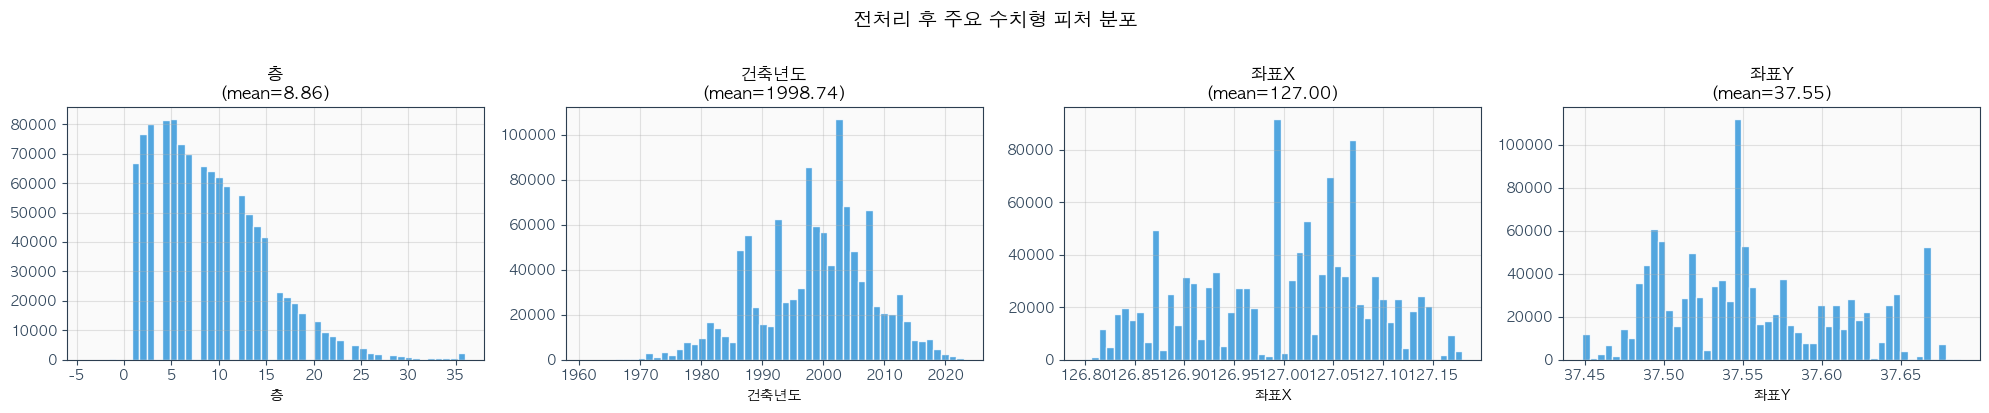

In [ ]:
# ── 전처리 후 수치형 피처 분포 확인 ──
key_numeric_cols = ["전용면적", "층", "건축년도", "좌표X", "좌표Y"]
available_cols = [c for c in key_numeric_cols if c in X_train.columns]

if available_cols:
    fig, axes = plt.subplots(1, len(available_cols), figsize=(5 * len(available_cols), 4))
    if len(available_cols) == 1:
        axes = [axes]

    for ax, col in zip(axes, available_cols):
        ax.hist(X_train[col].dropna(), bins=50, color=VIZ_COLORS["primary"], edgecolor="white", alpha=0.85)
        ax.set_title(f"{col}\n(mean={X_train[col].mean():.2f})", fontsize=12, fontweight="bold")
        ax.set_xlabel(col)

    plt.suptitle("전처리 후 주요 수치형 피처 분포", fontsize=14, y=1.02, fontweight="bold")
    plt.tight_layout()
    plt.show()

In [ ]:
# ── Train/Test 컬럼 일치 확인 ──
train_cols = set(X_train.columns)
test_cols = set(X_test.columns)

only_train = train_cols - test_cols
only_test = test_cols - train_cols
common = train_cols & test_cols

print(f"공통 컬럼: {len(common)}개")
if only_train:
    print(f"학습에만 있는 컬럼 ({len(only_train)}개): {sorted(only_train)}")
if only_test:
    print(f"테스트에만 있는 컬럼 ({len(only_test)}개): {sorted(only_test)}")

if not only_train and not only_test:
    print("학습/테스트 컬럼 완벽 일치!")

공통 컬럼: 51개
학습/테스트 컬럼 완벽 일치!


---

## 13. 통합 전처리 함수

위의 모든 단계를 하나의 함수로 통합합니다. 이후 파이프라인에서 바로 호출할 수 있습니다.

In [ ]:
def preprocess_train_data(
    train_df: pd.DataFrame,
    clip_target: bool = True,
) -> tuple:
    """학습 데이터 전처리 통합 함수

    Pipeline:
        Step 0  → 취소 거래 필터링
        Step 1  → Target 분리
        Step 2  → 고결측 컬럼 제거
        Step 2.5→ Float→Int64 타입 변환
        Step 3  → 컬럼명 정리 (LightGBM 호환)
        Step 3.5→ 날짜/주소 파생 피처 (계약일자, 구, 동, 건물나이)
        Step 4  → 범주형 컬럼 식별
        Step 5  → 결측 지표 피처 (missing_count)
        Step 6  → 좌표 보간 (Kakao API + 시군구 평균)
        Step 7  → 결측값 대체 (KNN Imputer — GPU 가속 자동 감지)
        Step 7.5→ 세대당 주차대수 파생 피처
        Step 8  → 이상치 클리핑 (IQR × 3.0)
        Step 9  → Target 로그 변환 (log1p)

    Returns:
        (X_train, y_train_log, categorical_cols, train_stats)
    """
    train_stats = {}

    # Step 0: 취소 거래 필터링
    print("[Step 0] 취소 거래 필터링")
    df = filter_cancelled_transactions(train_df)

    # Step 1: Target 분리
    print("\n[Step 1] Target 분리")
    y = df["target"].copy()
    X = df.drop(columns=["target"]).copy()
    print(f"  X: {X.shape}, y: {y.shape}")

    # Step 2: 고결측 컬럼 제거
    print("\n[Step 2] 고결측 컬럼 제거 (>{MISSING_THRESHOLD*100:.0f}%)")
    X = remove_high_missing_columns(X)

    # Step 2.5: Float→Int64 타입 변환
    print("\n[Step 2.5] Float→Int64 타입 변환")
    X = convert_float_to_int(X)

    # Step 3: 컬럼명 정리
    print("\n[Step 3] 컬럼명 정리 (LightGBM 호환)")
    X = sanitize_column_names(X)

    # Step 3.5: 날짜/주소 파생 피처
    print("\n[Step 3.5] 날짜/주소 파생 피처")
    X = add_date_address_features(X)

    # Step 4: 범주형 식별
    print("\n[Step 4] 범주형 컬럼 식별")
    cat_cols = identify_categorical_columns(X)

    # Step 5: 결측 지표 피처
    print("\n[Step 5] 결측 지표 피처 생성")
    X["missing_count"] = X.isnull().sum(axis=1)
    print(f"  missing_count 평균: {X['missing_count'].mean():.2f}")

    # Step 6: 좌표 보간
    print("\n[Step 6] 좌표 보간 (Kakao API + 시군구 평균)")
    X, coord_group_means, coord_global_means = interpolate_coordinates(X)
    train_stats["coord_group_means"] = coord_group_means
    train_stats["coord_global_means"] = coord_global_means

    # Step 7: 결측값 대체 (KNN — GPU 가속 자동 감지)
    print(f"\n[Step 7] 결측값 대체 (KNN k={KNN_N_NEIGHBORS})")
    X, knn_imp, knn_cols = handle_missing_values_knn(X, cat_cols)
    train_stats["knn_imputer"] = knn_imp
    train_stats["knn_numeric_cols"] = knn_cols

    # Step 7.5: 세대당 주차대수 파생 피처
    print("\n[Step 7.5] 세대당 주차대수 파생")
    X = add_parking_per_household(X)

    # Step 8: 이상치 클리핑
    print(f"\n[Step 8] 이상치 클리핑 (IQR × {OUTLIER_IQR_FACTOR})")
    X = clip_outliers(X, OUTLIER_CLIP_COLS)

    if clip_target:
        lower_pct = y.quantile(TARGET_LOWER_PERCENTILE)
        upper_pct = y.quantile(TARGET_UPPER_PERCENTILE)
        y = y.clip(lower=lower_pct, upper=upper_pct)
        print(f"  Target 클리핑: [{lower_pct:,.0f}, {upper_pct:,.0f}]")

    # Step 9: Target 로그 변환
    print("\n[Step 9] Target 로그 변환 (log1p)")
    y_log = log_transform_target(y)
    print(f"  변환 후 범위: [{y_log.min():.4f}, {y_log.max():.4f}]")

    print(f"\n{'='*50}")
    print(f"전처리 완료: X={X.shape}, y_log={y_log.shape}")
    print(f"{'='*50}")
    return X, y_log, cat_cols, train_stats


def preprocess_test_data(
    test_df: pd.DataFrame,
    categorical_cols: list,
    train_stats: dict = None,
) -> pd.DataFrame:
    """테스트 데이터 전처리 통합 함수

    학습 데이터에서 계산한 train_stats를 사용하여
    데이터 누수 없이 동일한 전처리를 적용합니다.
    """
    # Step 0: 취소 거래 필터링
    print("[Step 0] 취소 거래 필터링")
    X = filter_cancelled_transactions(test_df)

    # Step 2: 고결측 컬럼 제거
    print("\n[Step 2] 고결측 컬럼 제거")
    X = remove_high_missing_columns(X)

    # Step 2.5: Float→Int64 타입 변환
    print("\n[Step 2.5] Float→Int64 타입 변환")
    X = convert_float_to_int(X)

    # Step 3: 컬럼명 정리
    print("\n[Step 3] 컬럼명 정리")
    X = sanitize_column_names(X)

    # Step 3.5: 날짜/주소 파생 피처
    print("\n[Step 3.5] 날짜/주소 파생 피처")
    X = add_date_address_features(X)

    # Step 5: 결측 지표 피처
    print("\n[Step 5] 결측 지표 피처 생성")
    X["missing_count"] = X.isnull().sum(axis=1)

    # Step 6: 좌표 보간 (학습 기준 통계)
    print("\n[Step 6] 좌표 보간 (학습 기준 통계)")
    X, _, _ = interpolate_coordinates(X, stats=train_stats)

    # Step 7: 결측값 대체 (학습 기준 KNN — GPU 가속 자동 감지)
    print(f"\n[Step 7] 결측값 대체 (학습 기준 KNN)")
    knn_imp = train_stats.get("knn_imputer") if train_stats else None
    knn_cols = train_stats.get("knn_numeric_cols") if train_stats else None
    X, _, _ = handle_missing_values_knn(
        X, categorical_cols,
        fitted_imputer=knn_imp,
        numeric_cols_order=knn_cols,
    )

    # Step 7.5: 세대당 주차대수 파생 피처
    print("\n[Step 7.5] 세대당 주차대수 파생")
    X = add_parking_per_household(X)

    print(f"\n{'='*50}")
    print(f"테스트 전처리 완료: X={X.shape}")
    print(f"{'='*50}")
    return X


print("통합 전처리 함수 정의 완료")
print("  - preprocess_train_data(train_df) → (X, y_log, cat_cols, train_stats)")
print("  - preprocess_test_data(test_df, cat_cols, train_stats) → X_test")
print(f"\n  GPU 가속: {'✓ cuML (RAPIDS) 사용' if _USE_CUML else '✗ sklearn CPU 사용'}")

통합 전처리 함수 정의 완료
  - preprocess_train_data(train_df) → (X, y_log, cat_cols, train_stats)
  - preprocess_test_data(test_df, cat_cols, train_stats) → X_test


NameError: name '_USE_CUML' is not defined

---

## 14. 전처리 후 데이터 미리보기

In [ ]:
# ── 전처리 결과 미리보기 ──
print("X_train 상위 5행:")
X_train.head()

In [ ]:
# ── 전처리된 데이터 dtypes 확인 ──
print("컬럼별 dtype:")
X_train.dtypes

---

## 10. 전처리 결과 CSV 저장

전처리가 완료된 학습/테스트 데이터를 CSV 파일로 저장합니다.

| 파일 | 설명 |
|------|------|
| `X_train_preprocessed.csv` | 전처리 완료된 학습 피처 |
| `X_test_preprocessed.csv` | 전처리 완료된 테스트 피처 |
| `y_train_preprocessed.csv` | 전처리 완료된 학습 타겟 (log1p 변환 적용) |

> 저장 경로: `notebooks/data/` 디렉토리

In [ ]:
# ── 전처리 결과 CSV 저장 ──
output_dir = PROJECT_ROOT / "notebooks" / "data"
output_dir.mkdir(parents=True, exist_ok=True)

# 학습 피처
train_path = output_dir / "X_train_preprocessed.csv"
X_train.to_csv(train_path, index=False, encoding="utf-8-sig")
print(f"학습 피처 저장: {train_path}")
print(f"  shape: {X_train.shape}")

# 테스트 피처
test_path = output_dir / "X_test_preprocessed.csv"
X_test.to_csv(test_path, index=False, encoding="utf-8-sig")
print(f"테스트 피처 저장: {test_path}")
print(f"  shape: {X_test.shape}")

# 학습 타겟 (log1p 변환 적용된 상태)
target_path = output_dir / "y_train_preprocessed.csv"
y_train.to_csv(target_path, index=False, encoding="utf-8-sig", header=["target"])
print(f"학습 타겟 저장: {target_path}")
print(f"  shape: {y_train.shape}")

# 제출용 파일 (baseline: y_train 원본 스케일 median)
y_median_original = np.expm1(y_train).median()
submission_df = pd.DataFrame({
    "Id": np.arange(1, len(X_test) + 1),
    "target": np.full(len(X_test), y_median_original),
})
submission_path = output_dir / "submission.csv"
submission_df.to_csv(submission_path, index=False, encoding="utf-8-sig")
print(f"제출용 파일 저장: {submission_path}")
print(f"  shape: {submission_df.shape} (baseline: median={y_median_original:,.0f} 만원)")

print(f"\n전처리 결과 CSV 저장 완료 ({output_dir})")